## 1. Problem Definition and Algorithm

### 1.1 Tasks

The main tasks of this study are to find key features that affect an individual’s political orientation and to predict other interviewees’ political view using those detected features. Thus, the inputs of this study include individuals’ thoughts about various social and cultural issues (e.g. inequality, government’s role, gun law, homosexuality, death penalty, sex before marriage, belief in life after death etc.), attitudes towards other people (e.g. poor people, people in other races, criminals, etc.), lifestyle (hours per day watching TV, seen X-rated movie in last year, number of hours worked last week etc.), satisfaction of life (e.g. satisfaction with financial situation, job satisfaction, general happiness etc.), and basic information (e.g. age, gender, religion, income, race, marital status, education, political party affiliation etc.). The output is individuals’ political view.

### 1.2 Algorithm

This study used several algorithms to implement the tasks. In the process of data cleansing, it used multivariate feature imputation to address missing values, and in the data analysis stage, applied Decision Tree and Random Forest algorithms.
The General Social Survey (GSS) dataset used in this study includes many values such as “not applicable,” “don’t know,” and “no response” which don’t have much information we need. To deal with these responses, this study applied multivariate feature imputation in which a missing value is replaced with a predicted value. For example, if the value of a respondent’s attitudes towards inequality is missed, through the imputation algorithm, our machine finds other features which are observed and have a high correlation with the missing value. Individual’s age, religion, income, and thoughts about government’s role and homosexuality could be the features in this example. Regressing multiple times with these observed features, the missing attitudes towards inequality is replaced with a predicted value.
In the process of data analysis, this study used Decision Tree and Random Forest. Decision tree and Random Forest build classification or regression models in the form of a tree structure. While decision tree uses a tree, random forest, as its name decribes, builds a number of trees by bootstrapping and aggregates the result. Both algorithms split a data set into smaller and smaller subset by certain condition, and the final result is a tree with decision nodes and leaf nodes.

## 2. Methodology and Data Description

### 2.1 Research Design

To conduct the tasks, this study first designed $2\times2\times2$ research frame. Each term represents imputation, measurement and method, i.e. in our research frame, there are two different imputation methods, two different types of outputs, and two different algorithms. Thus the total eight different results came out. The $2\times2\times2$ research frame is as below.

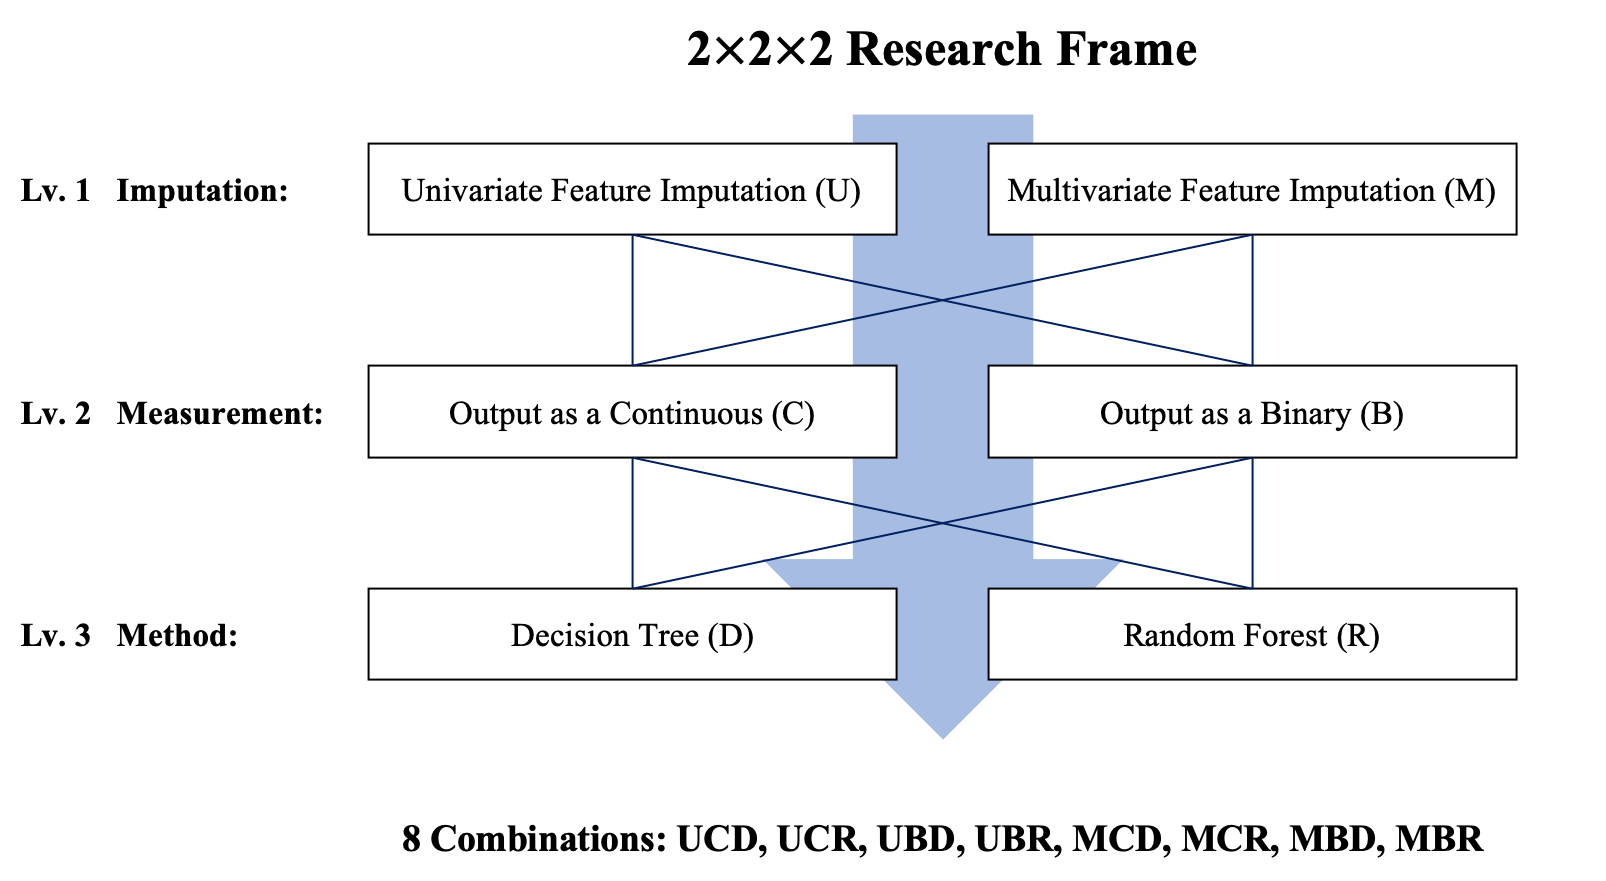

In [150]:
from PIL import Image
Image.open('research_frame.png')

### 2.2 Data Description

The General Social Survey (GSS) is the largest social survey data in the States conducted since 1972 to provide Americans’ social characteristics and attitudes toward various social issues. Among thousands of features provided by the GSS, this study carefully picked 61 features considering their possible relations with political orientation.(Please refer to the feature list in Appendix for details.)
The number of total obervations and features by model are as below.

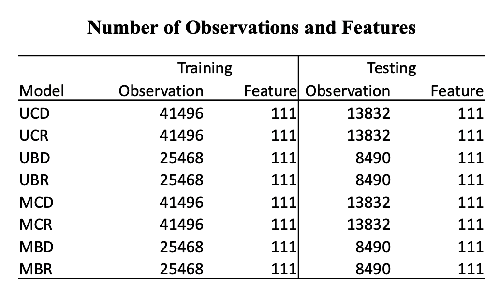

In [330]:
im1 = Image.open('features.png')
newsize = (500, 300) 
im1.resize(newsize)

### 2.3 Methodology

As mentioned in the task section, we implemented a 2 x 2 x 2 research design by using two different techniques to fill in the missing values, two different measures of output, and decision tree and random forest. We will test the hypothesis that the combination of MBR (multivariate feature imputation, binary output, Random Forest) out of 8 combinations results in the highest accuracy rate. We used Sklearn to split the training/test sets (test size = 0.25).

## 3. Experiments

### 3.1 Data and Packages Loading and Cleansing

In [163]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import export_graphviz 
from sklearn.ensemble import RandomForestRegressor
import pydot
import matplotlib.pyplot as plt

In [ ]:
def plot_decisiontree(img_name): 
    tree_image = plt.imread(img_name) 
    plt.figure(figsize=(100,10)) 
    plt.xticks([])
    plt.yticks([]) 
    plt.imshow(tree_image) 
    plt.show()

In [178]:
df = pd.read_csv("gss.csv")

In [179]:
df.head()

,Unnamed: 0,RELITEN,FAIR,TRUST,JOBLOSE,JOBFIND,SATJOB,RICHWORK,CLASS_,SATFIN,...,SPKHOMO,GRANBORN,INCOME,RINCOME,REGION,PARTYID,POLVIEWS,EQWLTH,TAX,ATTEND
0,1,0,2,3,0,0,3,0,3,3,...,0,-1,0,0,3,2,0,0,0,2
1,2,0,2,1,0,0,0,0,3,2,...,0,-1,0,0,3,1,0,0,0,7
2,3,0,1,2,0,0,2,0,2,1,...,0,-1,0,0,3,3,0,0,0,4
3,4,0,2,2,0,0,1,0,3,3,...,0,-1,0,0,3,1,0,0,0,0
4,5,0,2,2,0,0,0,0,2,1,...,0,-1,0,0,3,0,0,0,0,0


In [180]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [181]:
# Separate features by their characteristics and interviewees' response type
## continuous variables: 'con_var#_#', categorical variable: 'cat_var#_#'
con_var1_0 = ['PRESTG10','PAPRES10']
con_var2_089 = ['RELITEN','FAIR','JOBFIND','SATJOB','SATFIN','LIFE','HAPPY','HAPMAR','HEALTH',
                'HELPPOOR','HELPNOT','HELPSICK','HELPBLK','COOP','PREMARSX','HOMOSEX','NEWS',
                'COURTS','FUND','POLVIEWS','EQWLTH']
con_var3_n19899 = ['TVHOURS', 'HRS1']
con_var4_0589 = ['CLASS_']
con_var5_0489 = ['TAX']
con_var6_9 = ['CHILDS', 'ATTEND']
con_var7_02798 = ['RINCOM16', 'INCOME16']
con_var8_0139899 = ['INCOME', 'RINCOME']
con_var9_89 = ['DEGREE']
con_var10_789 = ['PADEG', 'MADEG']
con_var11_979899 = ['PAEDUC', 'MAEDUC', 'AGE', 'EDUC']
cat_var1 = ['REGION']
cat_var2_089 = ['POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE', 'FEAR', 'OWNGUN', 'HUNT',
                'SEX', 'RACE','BORN', 'CAPPUN', 'GUNLAW', 'GRASS']
cat_var3_9 = ['WRKSTAT', 'MARITAL']
cat_var5_09899 = ['SPREL', 'RELIG']
cat_var8_89 = ['PARTYID']

In [182]:
# Transform variables into proper form (change "don't know", "not applicable", and "no response" to NaN)
## Continuous variables
df1 = df[con_var1_0].replace(0, np.nan)
df2 = df[con_var2_089].replace([0,8,9], np.nan)
df3 = df[con_var3_n19899].replace([-1,98,99], np.nan)
df4 = df[con_var4_0589].replace([0,5,8,9], np.nan)
df5 = df[con_var5_0489].replace([0,4,8,9], np.nan)
df6 = df[con_var6_9].replace(9, np.nan)
df7 = df[con_var7_02798].replace([0,27,98], np.nan)
df8 = df[con_var8_0139899].replace([0,13,98,99], np.nan)
df9 = df[con_var9_89].replace([8,9], np.nan)
df10 = df[con_var10_789].replace([7,8,9], np.nan)
df11 = df[con_var11_979899].replace([97,98,99], np.nan)
## Categorica variables
df12 = df[cat_var1]
df13 = df[cat_var2_089].replace([0,8,9], np.nan)
df14 = df[cat_var3_9].replace(9, np.nan)
df15 = df[cat_var5_09899].replace([0,98,99], np.nan)
df16 = df[cat_var8_89].replace([8,9], np.nan)

In [183]:
# Bind all columns
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], axis=1)

In [184]:
# Drop NaN from "POLVIEWS" (dependent variable)
df.dropna(subset=['POLVIEWS'], inplace = True)
df.reset_index(inplace = True)

### 3.2 Experiments for each of 8 models

### *UCD (Univariate Feature Imputation - Continous output - Decision Tree)*

In [185]:
# Replace missing values
# For continuous values, replace with median & for categorical variable, replace with mode.

from scipy.stats import mode
vec_continuous = np.zeros(df.shape[1])
vec_continuous[0:40] = 1
def filling_missing(X,vec_continuous):
    for i in range(X.shape[1]):
        if vec_continuous[i] ==1:
            X.iloc[np.where(pd.isnull(X[X.columns[i]]))[0],i] = np.median(X.iloc[np.where(~pd.isnull(X[X.columns[i]]))[0],i])
        else:
            X.iloc[np.where(pd.isnull(X[X.columns[i]]))[0],i] = mode(X.iloc[np.where(~pd.isnull(X[X.columns[i]]))[0],i])[0]
    return X

imp_df = filling_missing(df,vec_continuous)
imp_df = imp_df.drop('index', axis = 1)

In [189]:
imp_df.head()

,PRESTG10,PAPRES10,RELITEN,FAIR,JOBFIND,SATJOB,SATFIN,LIFE,HAPPY,HAPMAR,...,RACE,BORN,CAPPUN,GUNLAW,GRASS,WRKSTAT,MARITAL,SPREL,RELIG,PARTYID
0,25.0,50.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1,1.0,1.0,1.0,2.0,6.0,1.0,1.0,1.0,2.0
1,66.0,49.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,...,1,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0
2,43.0,46.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,1,1.0,1.0,1.0,2.0,7.0,2.0,1.0,1.0,0.0
3,43.0,34.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,1,1.0,1.0,1.0,2.0,7.0,2.0,1.0,1.0,0.0
4,37.0,46.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1,1.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0


In [190]:
# Get the label value we want to predict, separate it from the feature dataframe
labels = np.array(imp_df['POLVIEWS'])
imp_df = imp_df.drop('POLVIEWS', axis=1)
feature_list = list(imp_df.columns)

In [191]:
# One-hot encoding for transforming categorical variables.
cat_var = ['REGION', 'POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE',
           'FEAR', 'OWNGUN', 'HUNT','SEX', 'RACE', 'BORN', 'CAPPUN', 'GUNLAW', 'GRASS', 
           'WRKSTAT', 'MARITAL','SPREL', 'RELIG', 
           'PARTYID']
imp_df = pd.get_dummies(imp_df, columns = cat_var, drop_first = True)

In [192]:
imp_df.shape

(55328, 111)

In [193]:
# Separate the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(imp_df, labels, test_size = 0.25, random_state = 3)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (41496, 111)
Training Labels Shape: (41496,)
Testing Features Shape: (13832, 111)
Testing Labels Shape: (13832,)


In [194]:
# Using political view as a continuous variable (1 to 7)
# Decision tree with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    dt = tree.DecisionTreeRegressor(max_depth = vec_max_depth[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_accuracy[i] = 100-mape_train
    predictions = dt.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_accuracy[i] = 100-mape_test
print(vec_train_accuracy)
print(vec_test_accuracy)

[65.28247067 65.05320287 66.56971799 66.90912546 67.79882391 68.2161858
 68.96364867 69.49940311 70.33555491 71.18626069 72.28304119 73.57173857
 75.09750081 76.89556092 78.85863844 80.88862569 82.88167895 84.78133739
 86.77577475 88.65208282 90.24617335 91.68779521 92.94339856 94.09125607
 95.1615755  95.99849776 96.74609452 97.32436383 97.87345746 98.33310479]
[66.6955146  66.30204279 67.63075292 67.81690546 68.437917   68.56830283
 68.97270756 68.92605871 69.02192972 68.78103886 68.55248454 68.28244785
 67.67052395 66.95202909 66.28780852 65.5869101  64.97346795 64.19352114
 63.49863075 63.13075118 62.70104984 62.39719132 61.90426886 61.66293747
 61.26982687 61.21941599 60.94038559 61.06111428 60.44975037 60.70931679]


In [195]:
# Decision tree with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 70
vec_min_samples_leaf = np.arange(1,71)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    dt = tree.DecisionTreeRegressor(min_samples_leaf = vec_min_samples_leaf[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_min_sample_accuracy[i] = 100-mape_train
    predictions = dt.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_min_sample_accuracy[i] = 100-mape_test
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[100.          93.82669318  88.6951413   84.93178557  82.22532876
  80.34044886  78.83915395  77.76266921  76.92589743  76.17821476
  75.58936933  75.12714749  74.69903304  74.3144962   73.9711573
  73.71306034  73.43696947  73.19521448  73.01067321  72.80083994
  72.57732272  72.43815815  72.32724712  72.1921819   72.04670068
  71.90309434  71.80309473  71.70506233  71.60676873  71.51155953
  71.39151583  71.35889465  71.28831974  71.18885369  71.14174296
  71.08622392  71.038323    70.97852615  70.9058111   70.8705719
  70.80205631  70.75793025  70.71551738  70.65924297  70.64238706
  70.5977936   70.58364629  70.53704855  70.5222423   70.46954307
  70.440972    70.40443674  70.37922267  70.33584403  70.30109243
  70.2792809   70.26489041  70.25524732  70.24309613  70.22517156
  70.18308704  70.16171013  70.14582283  70.11003518  70.08539967
  70.05799261  70.05751375  70.04502973  70.03713554  70.02177825]
[60.35760762 60.89743877 61.68785718 62.8657079  63.61744801 64.02376073
 64.

Text(0.5, 1.0, "Accuracy of UCD ('max_depth': 1 to 30)")

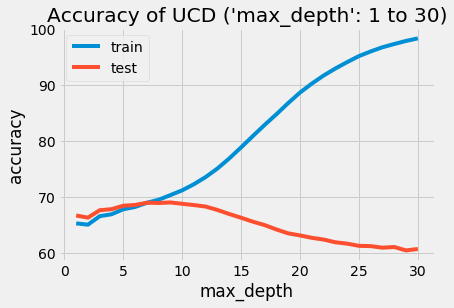

In [196]:
# Plot accuracy (max_depth varies)
plt.style.use('fivethirtyeight')
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of UCD ('max_depth': 1 to 30)")

Text(0.5, 1.0, "Accuracy of UCD ('min_samples_leaf': 1 to 50)")

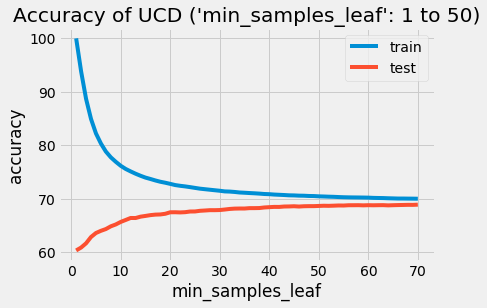

In [197]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of UCD ('min_samples_leaf': 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 9. For 'min_samples_leaf', as the value increases, the accuracy converges to around 69.0.**

In [199]:
# UCD using the best values of parameter
dt_best = tree.DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 25)
dt_best.fit(X_train,y_train)

# Predict on the train dataset and get accuracy
predictions = dt_best.predict(X_train)
errors_train = abs(predictions - y_train)
mape_train = np.mean(100*(errors_train/y_train))
ucd_accuracy_train = 100 - mape_train

# Predict on the test dataset and get accuracy
predictions = dt_best.predict(X_test)
errors_test = abs(predictions - y_test)
mape_test = np.mean(100*(errors_test/y_test))
ucd_accuracy_test = 100 - mape_test

print("[UCD] Accuracy for Train: ", round(np.mean(ucd_accuracy_train),2), "%.")
print("[UCD] Accuracy for Test: ", round(np.mean(ucd_accuracy_test),2), "%.")

[UCD] Accuracy for Train:  69.76 %.
[UCD] Accuracy for Test:  68.91 %.


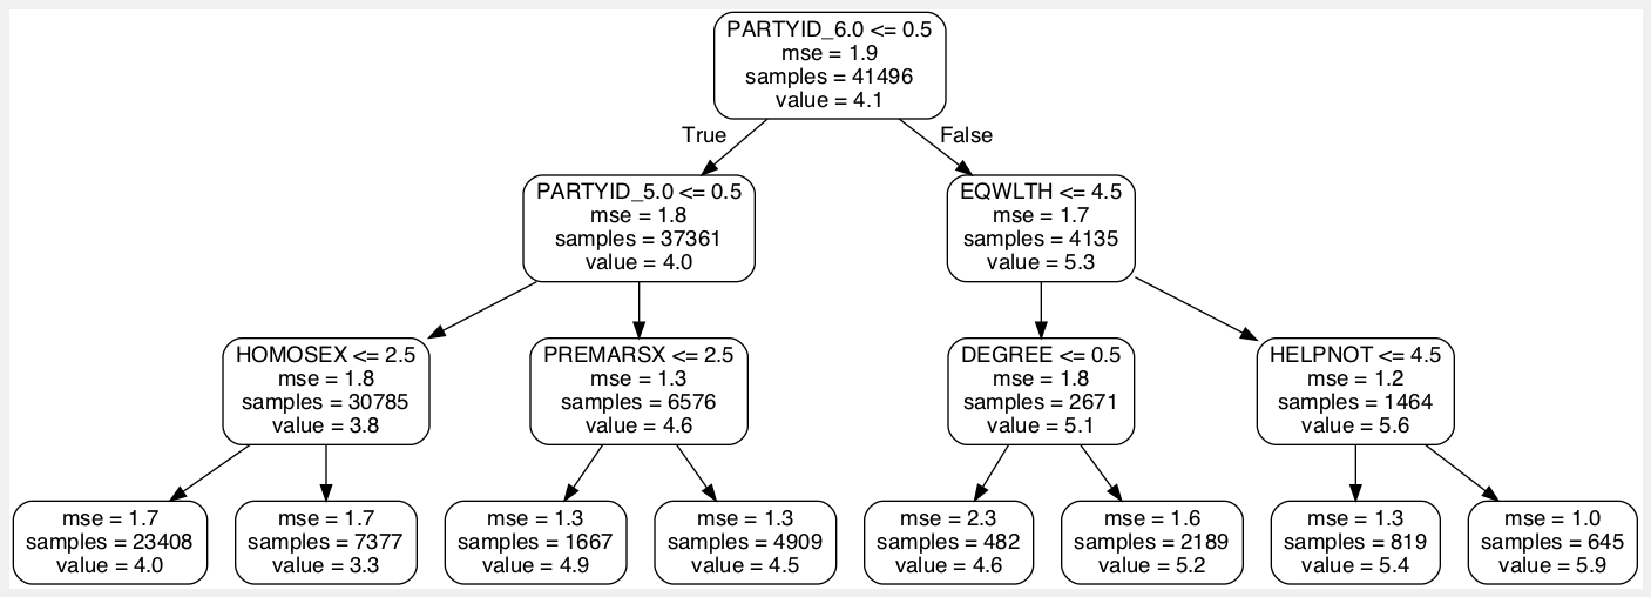

In [200]:
# Plot Decision Tree to 3 level ('max_depth = 3')
dt_small = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 20)
dt_small.fit(X_train, y_train)
export_graphviz(dt_small, out_file = 'ucd_small_tree.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('ucd_small_tree.dot')
graph_best.write_png('ucd_small_tree.png')

plot_decisiontree('ucd_small_tree.png')

In [201]:
# Get numerical feature importances
importances = list(dt_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.28
Variable: PARTYID_5.0          Importance: 0.13
Variable: HOMOSEX              Importance: 0.11
Variable: PARTYID_4.0          Importance: 0.07
Variable: EDUC                 Importance: 0.05
Variable: PREMARSX             Importance: 0.04
Variable: GRASS_2.0            Importance: 0.04
Variable: HELPNOT              Importance: 0.03
Variable: EQWLTH               Importance: 0.03
Variable: CAPPUN_2.0           Importance: 0.03
Variable: ATTEND               Importance: 0.02
Variable: DEGREE               Importance: 0.02
Variable: AGE                  Importance: 0.02
Variable: ABANY_2.0            Importance: 0.02
Variable: PRESTG10             Importance: 0.01
Variable: HELPBLK              Importance: 0.01
Variable: FUND                 Importance: 0.01
Variable: CHILDS               Importance: 0.01
Variable: INCOME               Importance: 0.01
Variable: RACE_2               Importance: 0.01
Variable: PARTYID_3.0          Importanc

### *UCR (Univariate Feature Imputation - Continous output - Random Forest)*

In [202]:
# The number of features is 111, and we set up n_estimators 10 (around the square root of 111)
# Random Forest with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    rf = RandomForestRegressor(max_depth = vec_max_depth[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_accuracy[i] = 100-mape_train
    predictions = rf.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_accuracy[i] = 100-mape_test
print(vec_train_accuracy)
print(vec_test_accuracy)

[65.27979359 65.06400225 66.61137735 66.9929172  67.9201037  68.46467865
 69.18959178 69.86314518 70.55900732 71.35945735 72.2766901  73.32714423
 74.49934295 75.74127364 76.98870421 78.21307359 79.41675742 80.56559479
 81.57616919 82.48402882 83.2893981  83.97732734 84.54783313 85.04244554
 85.51530358 85.88167093 86.22940781 86.49995563 86.71112518 86.89692087]
[66.69171687 66.31375115 67.68973881 67.95135113 68.59694716 68.90745983
 69.3301309  69.55622843 69.67874245 69.75303289 69.79265257 69.76927673
 69.71765806 69.71373151 69.55772783 69.54189163 69.47154367 69.36689383
 69.29031009 69.18574517 69.16994994 69.10157802 69.00032238 68.92536625
 68.90053786 68.92707386 68.79068929 68.81883364 68.76774016 68.77023437]


In [203]:
# Random Forest with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 50
vec_min_samples_leaf = np.arange(1,51)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    rf = RandomForestRegressor(min_samples_leaf = vec_min_samples_leaf[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_min_sample_accuracy[i] = 100-mape_train
    predictions = rf.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_min_sample_accuracy[i] = 100-mape_test
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[87.60505086 85.61618101 83.40892295 81.4921365  79.87612741 78.63227137
 77.6644109  76.88577748 76.20202259 75.58983274 75.1368587  74.75232252
 74.37464547 74.06369974 73.79862178 73.5247394  73.31418208 73.11072544
 72.93954563 72.8114801  72.63280631 72.49869294 72.37294097 72.2575355
 72.1624721  72.04539362 71.95413094 71.87182357 71.77260303 71.69483311
 71.61861411 71.56056209 71.5006475  71.4439555  71.38087566 71.31876881
 71.26321019 71.20104113 71.14425478 71.09083772 71.04931275 71.01275171
 70.96321738 70.91443454 70.88776157 70.83546139 70.79780751 70.76170642
 70.73273199 70.68960062]
[68.73504675 68.77316518 69.05805433 69.19451198 69.14945016 69.35580731
 69.46034368 69.5239177  69.49150618 69.5866171  69.68080284 69.71586806
 69.72807941 69.71596629 69.75723155 69.70208711 69.75227935 69.76247619
 69.7555498  69.80485426 69.8099476  69.81533541 69.81127661 69.79880609
 69.79711902 69.80621716 69.8060626  69.8513514  69.85811043 69.84453686
 69.83109547 69.8302654  6

Text(0.5, 1.0, "Accuracy of UCR ('max_depth' varies 1 to 30)")

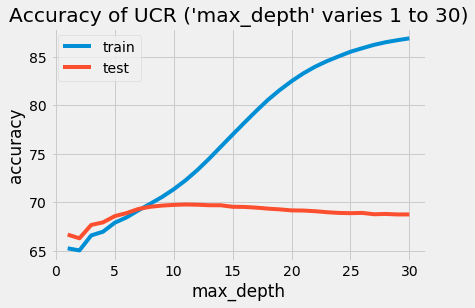

In [204]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of UCR ('max_depth' varies 1 to 30)")

Text(0.5, 1.0, "Accuracy of UCR ('min_samples_leaf' varies 1 to 50)")

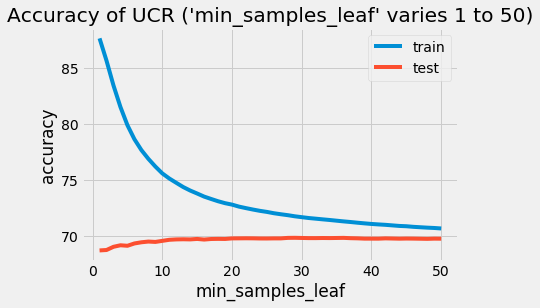

In [205]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of UCR ('min_samples_leaf' varies 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 11. For 'min_samples_leaf', as the value increases, the accuracy converges to around 69.8.**

In [206]:
# Random Forest using the best values of parameter
rf_best = RandomForestRegressor(max_depth = 11, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=11, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=25,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [207]:
# Predict on the train dataset and get accuracy
predictions = rf_best.predict(X_train)
errors_train = abs(predictions - y_train)
mape_train = np.mean(100*(errors_train/y_train))
ucr_accuracy_train = 100 - mape_train

In [208]:
# Predict on the test dataset and get accuracy
predictions = rf_best.predict(X_test)
errors_test = abs(predictions - y_test)
mape_test = np.mean(100*(errors_test/y_test))
ucr_accuracy_test = 100 - mape_test

print("[UCR] Accuracy for Train: ", round(np.mean(ucr_accuracy_train),2), "%.")
print("[UCR] Accuracy for Test: ", round(np.mean(ucr_accuracy_test),2), "%.")

[UCR] Accuracy for Train:  70.83 %.
[UCR] Accuracy for Test:  69.78 %.


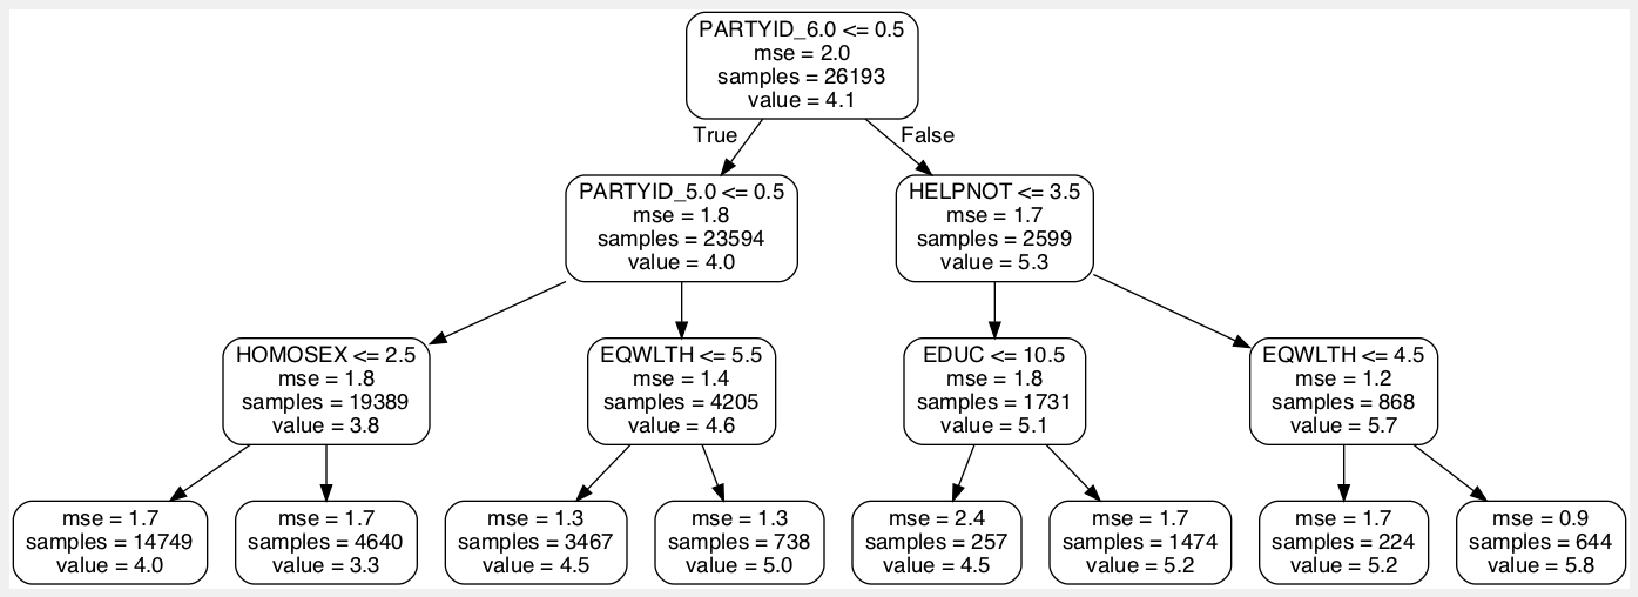

In [209]:
# Plot One of the Random Forest Trees to 3 level ('max_depth = 3')
rf_small = RandomForestRegressor(max_depth = 3, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_small.fit(X_train, y_train)
tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'ucr_small.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('ucr_small.dot')
graph_best.write_png('ucr_small.png')

plot_decisiontree('ucr_small.png')

In [210]:
# Get numerical feature importances
importances = list(rf_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.24
Variable: PARTYID_5.0          Importance: 0.11
Variable: HOMOSEX              Importance: 0.09
Variable: PARTYID_4.0          Importance: 0.06
Variable: EDUC                 Importance: 0.05
Variable: PREMARSX             Importance: 0.04
Variable: EQWLTH               Importance: 0.03
Variable: ATTEND               Importance: 0.03
Variable: AGE                  Importance: 0.03
Variable: CAPPUN_2.0           Importance: 0.03
Variable: HELPNOT              Importance: 0.02
Variable: GRASS_2.0            Importance: 0.02
Variable: PARTYID_3.0          Importance: 0.02
Variable: PRESTG10             Importance: 0.01
Variable: PAPRES10             Importance: 0.01
Variable: RELITEN              Importance: 0.01
Variable: HELPPOOR             Importance: 0.01
Variable: HELPSICK             Importance: 0.01
Variable: HELPBLK              Importance: 0.01
Variable: FUND                 Importance: 0.01
Variable: TVHOURS              Importanc

### *UBD (Univariate Feature Imputation - Binary output - Decision Tree)*

In [335]:
# Political view as a binary variable (0 or 1)

# Reload our basic dataset
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], axis=1)

# Drop NaN from "POLVIEWS" (dependent variable)
df.dropna(subset=['POLVIEWS'], inplace = True)
df.reset_index(inplace = True)

In [336]:
# Remove Moderate view (POLVIEWS = 4)
df = df[df.POLVIEWS != 4]
# Change extremely liberal(=1), liberal(=2), and slighly liberal(=3) to 0
df['POLVIEWS'] = df['POLVIEWS'].replace([1,2,3], 0)
# Change extremely conservative(=7), conservative(=6), and slighly conservative(=5) to 1
df['POLVIEWS'] = df['POLVIEWS'].replace([5,6,7], 1)

# Check 'POLVIEWS'
df['POLVIEWS'].unique()

array([1., 0.])

In [337]:
# Replace missing values
# For continuous values, replace with median & for categorical variable, replace with mode.

from scipy.stats import mode
vec_continuous = np.zeros(df.shape[1])
vec_continuous[0:40] = 1
def filling_missing(X,vec_continuous):
    for i in range(X.shape[1]):
        if vec_continuous[i] ==1:
            X.iloc[np.where(pd.isnull(X[X.columns[i]]))[0],i] = np.median(X.iloc[np.where(~pd.isnull(X[X.columns[i]]))[0],i])
        else:
            X.iloc[np.where(pd.isnull(X[X.columns[i]]))[0],i] = mode(X.iloc[np.where(~pd.isnull(X[X.columns[i]]))[0],i])[0]
    return X

imp_df = filling_missing(df,vec_continuous)
imp_df = imp_df.drop('index', axis = 1)

imp_df.head()

,PRESTG10,PAPRES10,RELITEN,FAIR,JOBFIND,SATJOB,SATFIN,LIFE,HAPPY,HAPMAR,...,RACE,BORN,CAPPUN,GUNLAW,GRASS,WRKSTAT,MARITAL,SPREL,RELIG,PARTYID
1,66.0,49.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,...,1,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0
2,44.0,46.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,1,1.0,1.0,1.0,2.0,7.0,2.0,1.0,1.0,0.0
3,44.0,34.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,1,1.0,1.0,1.0,2.0,7.0,2.0,1.0,1.0,0.0
4,37.0,46.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1,1.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0
5,45.0,38.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1,1.0,1.0,2.0,2.0,6.0,1.0,2.0,1.0,4.0


In [338]:
# Get the label value we want to predict, separate it from the feature dataframe
labels = np.array(imp_df['POLVIEWS'])
imp_df = imp_df.drop('POLVIEWS', axis=1)
feature_list = list(imp_df.columns)

In [339]:
# One-hot encoding for transforming categorical variables.
cat_var = ['REGION', 'POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE',
           'FEAR', 'OWNGUN', 'HUNT','SEX', 'RACE', 'BORN', 'CAPPUN', 'GUNLAW', 'GRASS', 
           'WRKSTAT', 'MARITAL','SPREL', 'RELIG', 
           'PARTYID']
imp_df = pd.get_dummies(imp_df, columns = cat_var, drop_first = True)

imp_df.shape

(33958, 111)

In [340]:
# Separate the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(imp_df, labels, test_size = 0.25, random_state = 3)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (25468, 111)
Training Labels Shape: (25468,)
Testing Features Shape: (8490, 111)
Testing Labels Shape: (8490,)


In [220]:
# Decision tree with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    dt = tree.DecisionTreeRegressor(max_depth = vec_max_depth[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    vec_train_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = dt.predict(X_test)
    vec_test_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_accuracy)
print(vec_test_accuracy)

[0.55277211 0.64386681 0.68945343 0.68976755 0.70390294 0.71128475
 0.72565572 0.74089053 0.7552615  0.76719805 0.78258992 0.80245799
 0.82291503 0.84623842 0.86642061 0.88723104 0.90321187 0.92037066
 0.93513429 0.94820952 0.95987121 0.96878436 0.97663735 0.98280195
 0.98661065 0.99045861 0.99367834 0.99520967 0.99693733 0.9985472 ]
[0.55053004 0.64852768 0.69234393 0.69128386 0.70541814 0.70518257
 0.71531213 0.71731449 0.71625442 0.71366313 0.70800942 0.69776207
 0.69069494 0.69234393 0.68504122 0.68138987 0.67738516 0.67279152
 0.67491166 0.66855124 0.66996466 0.66890459 0.66678445 0.66878681
 0.66383981 0.6614841  0.66372203 0.65877503 0.6631331  0.6639576 ]


In [221]:
# Decision tree with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 70
vec_min_samples_leaf = np.arange(1,71)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    dt = tree.DecisionTreeRegressor(min_samples_leaf = vec_min_samples_leaf[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    vec_train_min_sample_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = dt.predict(X_test)
    vec_test_min_sample_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[1.         0.95782943 0.932425   0.90599969 0.88907649 0.87227109
 0.85797864 0.8473771  0.83783572 0.831357   0.8242893  0.81843883
 0.81408041 0.80995759 0.80516727 0.80245799 0.79719648 0.79389823
 0.79071776 0.78953981 0.78851893 0.78690906 0.7843961  0.78251139
 0.78117638 0.7783493  0.77626826 0.77465839 0.77328412 0.77234176
 0.77065337 0.76931836 0.76861159 0.76790482 0.76727658 0.76723732
 0.76649128 0.7652348  0.76452804 0.76362494 0.7629967  0.76272185
 0.76276111 0.76244699 0.76174022 0.76079786 0.76068007 0.76048374
 0.75958065 0.75895241 0.75883462 0.75867756 0.75855976 0.75824564
 0.75797079 0.75757814 0.75714622 0.75730328 0.75730328 0.75702843
 0.75671431 0.75659651 0.75636092 0.75569342 0.75553636 0.75518297
 0.7547118  0.75463327 0.75455474 0.7530234 ]
[0.66277974 0.66007067 0.65630153 0.66266196 0.67302709 0.66996466
 0.68080094 0.68268551 0.68563015 0.68928151 0.69305065 0.69575972
 0.693404   0.69776207 0.70212014 0.70365135 0.70447585 0.7024735
 0.70553592 0.709

Text(0.5, 1.0, "Accuracy of UBD ('max_depth': 1 to 30)")

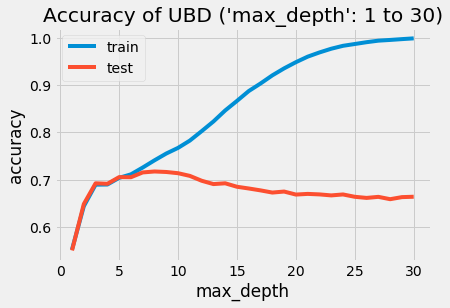

In [222]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of UBD ('max_depth': 1 to 30)")

Text(0.5, 1.0, "Accuracy of UBD ('min_samples_leaf': 1 to 50)")

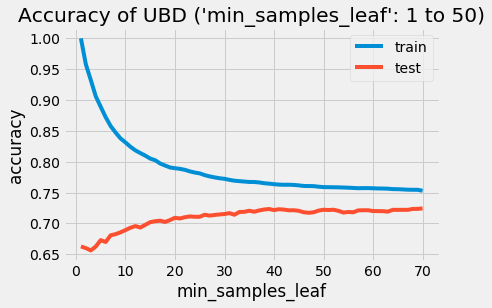

In [223]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of UBD ('min_samples_leaf': 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 8. For 'min_samples_leaf', as the value increases, the accuracy converges to around 72.5.**

In [225]:
# UBD using the best values of parameter
dt_best = tree.DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 25)
dt_best.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=25, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [227]:
# Predict on the train dataset and get accuracy
predictions = dt_best.predict(X_train)
ubd_accuracy_train = ((predictions.round()==y_train).sum()/len(y_train))*100
# Predict on the test dataset and get accuracy
predictions = dt_best.predict(X_test)
ubd_accuracy_test = ((predictions.round()==y_test).sum()/len(y_test))*100

print("[UBD] Accuracy for Train: ", round(np.mean(ubd_accuracy_train),2), "%.")
print("[UBD] Accuracy for Test: ", round(np.mean(ubd_accuracy_test),2), "%.")

[UBD] Accuracy for Train:  73.41 %.
[UBD] Accuracy for Test:  72.44 %.


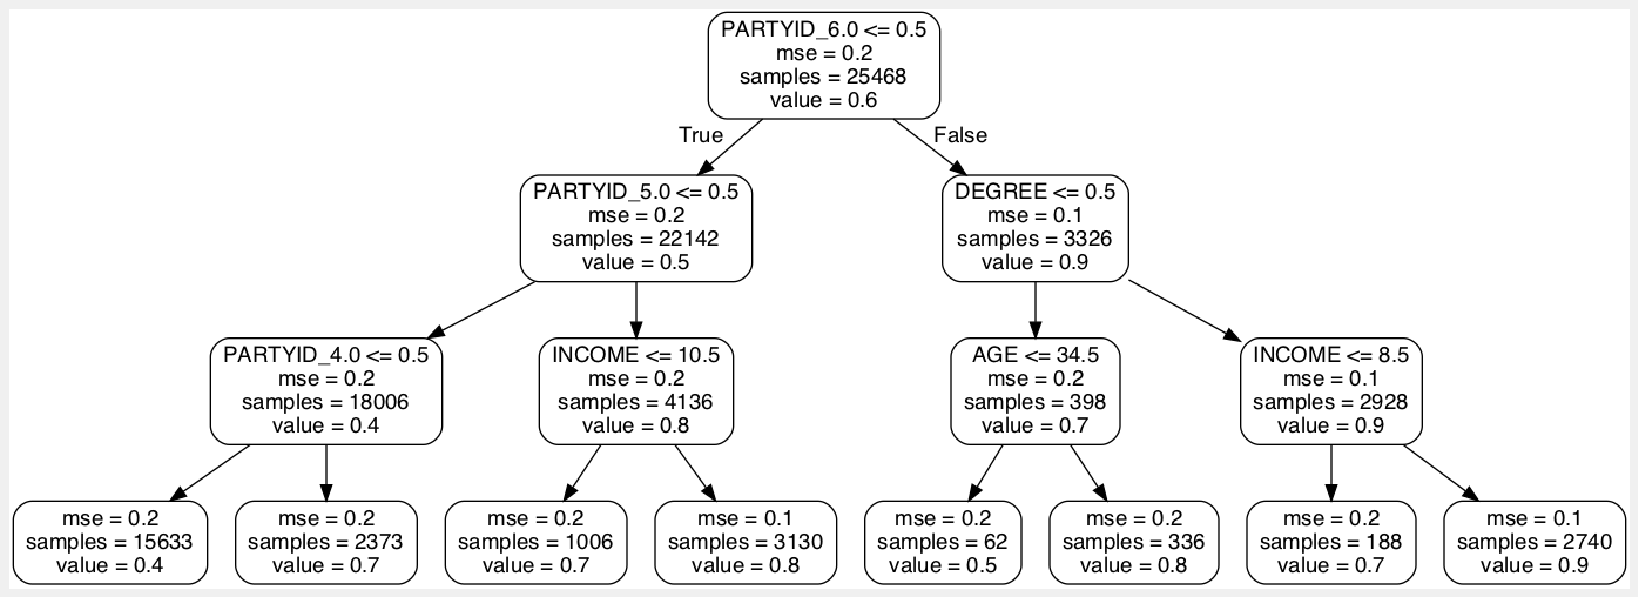

In [229]:
# Plot Decision Tree to 3 level ('max_depth = 3')
dt_small = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 20)
dt_small.fit(X_train, y_train)
export_graphviz(dt_small, out_file = 'ubd_small_tree.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('ubd_small_tree.dot')
graph_best.write_png('ubd_small_tree.png')

plot_decisiontree('ubd_small_tree.png')

In [230]:
# Get numerical feature importances
importances = list(dt_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.23
Variable: PARTYID_5.0          Importance: 0.22
Variable: PARTYID_4.0          Importance: 0.13
Variable: HOMOSEX              Importance: 0.11
Variable: PREMARSX             Importance: 0.06
Variable: EDUC                 Importance: 0.05
Variable: AGE                  Importance: 0.03
Variable: ATTEND               Importance: 0.02
Variable: INCOME               Importance: 0.02
Variable: PARTYID_3.0          Importance: 0.02
Variable: HELPPOOR             Importance: 0.01
Variable: HELPSICK             Importance: 0.01
Variable: EQWLTH               Importance: 0.01
Variable: DEGREE               Importance: 0.01
Variable: ABANY_2.0            Importance: 0.01
Variable: CAPPUN_2.0           Importance: 0.01
Variable: GRASS_2.0            Importance: 0.01
Variable: PRESTG10             Importance: 0.0
Variable: PAPRES10             Importance: 0.0
Variable: RELITEN              Importance: 0.0
Variable: FAIR                 Importance: 

### *UBR (Univariate Feature Imputation - Binary output - Random Forest)*

In [341]:
# The number of features is 111, and we set up n_estimators 10 (around the square root of 111)
# Random Forest with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    rf = RandomForestRegressor(max_depth = vec_max_depth[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    vec_train_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = rf.predict(X_test)
    vec_test_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_accuracy)
print(vec_test_accuracy)

[0.55277211 0.64386681 0.68945343 0.68976755 0.7156039  0.72679441
 0.73504005 0.74960735 0.76566672 0.78388566 0.80803361 0.83178891
 0.85931365 0.88526779 0.90690278 0.92696717 0.94357625 0.95476677
 0.9648186  0.97212188 0.97718706 0.9801712  0.98264489 0.98437255
 0.9861002  0.98617873 0.98727815 0.98739595 0.98633579 0.98747448]
[0.55053004 0.64852768 0.69234393 0.69222615 0.71660777 0.72308598
 0.72438163 0.72767962 0.73262662 0.73981154 0.73557126 0.7352179
 0.73121319 0.73109541 0.72815077 0.71896349 0.71625442 0.71531213
 0.71813899 0.71189635 0.71107185 0.71177856 0.7147232  0.71378092
 0.71342756 0.71425206 0.71130742 0.71330978 0.71248528 0.71224971]


In [342]:
# Random Forest with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 50
vec_min_samples_leaf = np.arange(1,51)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    rf = RandomForestRegressor(min_samples_leaf = vec_min_samples_leaf[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    vec_train_min_sample_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = rf.predict(X_test)
    vec_test_min_sample_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)

print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[0.98664991 0.97220041 0.95111512 0.93309251 0.91510916 0.90144495
 0.88750589 0.87403801 0.8687765  0.85719334 0.84937961 0.83991676
 0.83622585 0.82935448 0.82558505 0.82087325 0.81761426 0.81372703
 0.81011465 0.80583477 0.80430344 0.80041621 0.79688236 0.79401602
 0.79130674 0.79075703 0.78926496 0.78738024 0.78573111 0.78392493
 0.78239359 0.78156903 0.77909534 0.77823151 0.77670017 0.77724988
 0.77465839 0.77497251 0.77304853 0.77297    0.77300927 0.77183132
 0.77069263 0.76904351 0.76959322 0.76829747 0.76786556 0.76700173
 0.76633422 0.76570598]
[0.71295642 0.71460542 0.72084806 0.7196702  0.72650177 0.72873969
 0.7262662  0.72779741 0.72979976 0.7343934  0.73309776 0.73674912
 0.73651355 0.73828033 0.7368669  0.73757362 0.73498233 0.7368669
 0.73816254 0.73839812 0.7385159  0.73616019 0.73863369 0.74051826
 0.7409894  0.74146054 0.74004711 0.74122497 0.73981154 0.74075383
 0.73757362 0.7368669  0.73969376 0.73922261 0.74004711 0.74028269
 0.74122497 0.74028269 0.74146054 0.740

Text(0.5, 1.0, "Accuracy of UBR ('max_depth' varies 1 to 30)")

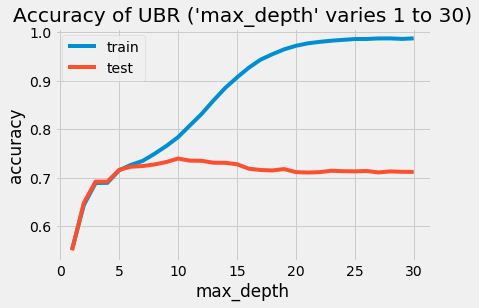

In [343]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of UBR ('max_depth' varies 1 to 30)")

Text(0.5, 1.0, "Accuracy of UBR ('min_samples_leaf' varies 1 to 50)")

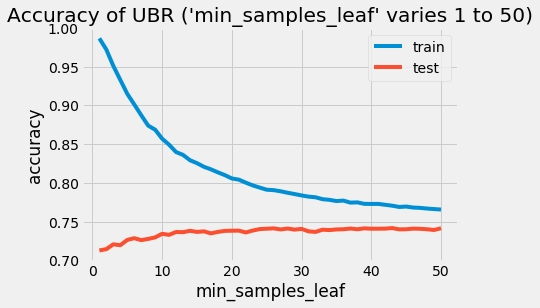

In [344]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of UBR ('min_samples_leaf' varies 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 10. For 'min_samples_leaf', as the value increases, the accuracy converges to around 74.2.**

In [345]:
# Random Forest using the best values of parameter
rf_best = RandomForestRegressor(max_depth = 10, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=25,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [346]:
# Predict on the train dataset and get accuracy
predictions = rf_best.predict(X_train)
ubr_accuracy_train = ((predictions.round()==y_train).sum()/len(y_train))*100
predictions = rf_best.predict(X_test)
ubr_accuracy_test = ((predictions.round()==y_test).sum()/len(y_test))*100

print("[UBR] Accuracy for Train: ", round(np.mean(ubr_accuracy_train),2), "%.")
print("[UBR] Accuracy for Test: ", round(np.mean(ubr_accuracy_test),2), "%.")

[UBR] Accuracy for Train:  75.53 %.
[UBR] Accuracy for Test:  73.77 %.


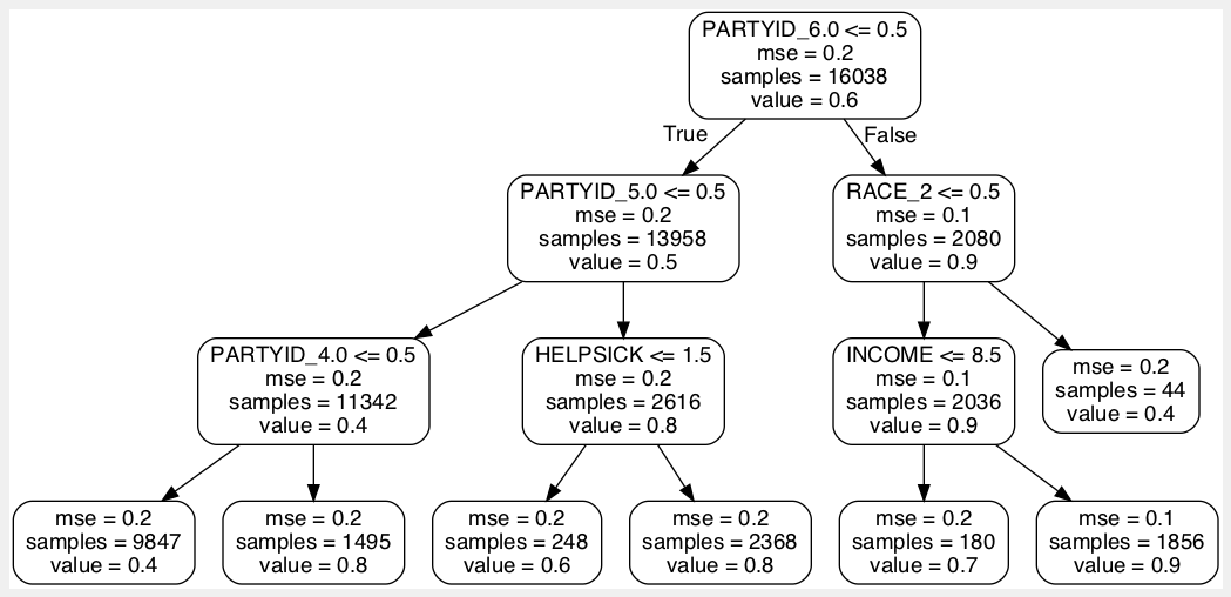

In [240]:
# Plot One of the Random Forest Trees to 3 level ('max_depth = 3')
rf_small = RandomForestRegressor(max_depth = 3, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_small.fit(X_train, y_train)
tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'ubr_small.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('ubr_small.dot')
graph_best.write_png('ubr_small.png')

plot_decisiontree('ubr_small.png')

In [241]:
# Get numerical feature importances
importances = list(rf_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.2
Variable: PARTYID_5.0          Importance: 0.19
Variable: PARTYID_4.0          Importance: 0.11
Variable: HOMOSEX              Importance: 0.1
Variable: PREMARSX             Importance: 0.05
Variable: EDUC                 Importance: 0.05
Variable: AGE                  Importance: 0.04
Variable: GRASS_2.0            Importance: 0.03
Variable: ATTEND               Importance: 0.02
Variable: PRESTG10             Importance: 0.01
Variable: PAPRES10             Importance: 0.01
Variable: HELPPOOR             Importance: 0.01
Variable: HELPNOT              Importance: 0.01
Variable: HELPSICK             Importance: 0.01
Variable: HELPBLK              Importance: 0.01
Variable: FUND                 Importance: 0.01
Variable: EQWLTH               Importance: 0.01
Variable: INCOME               Importance: 0.01
Variable: RINCOME              Importance: 0.01
Variable: DEGREE               Importance: 0.01
Variable: MAEDUC               Importance:

In [9]:
# Get the label value we want to predict, separate it from the feature dataframe
labels = np.array(df['POLVIEWS'])
df = df.drop('POLVIEWS', axis=1)
feature_list = list(df.columns)

In [10]:
# One-hot encoding for transforming categorical variables.
cat_var = ['REGION', 'POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE',
           'FEAR', 'OWNGUN', 'HUNT','SEX', 'RACE', 'BORN', 'CAPPUN', 'GUNLAW', 'GRASS', 
           'WRKSTAT', 'MARITAL','SPREL', 'RELIG', 
           'PARTYID']
df_dum = pd.get_dummies(df, columns = cat_var, drop_first = True)

In [11]:
df_dum.shape

(55328, 112)

### *MCD (Multivariate Feature Imputation - Continuous output - Decision Tree)*

In [244]:
# Reload Dataset
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], axis=1)

# Drop NaN from "POLVIEWS" (dependent variable)
df.dropna(subset=['POLVIEWS'], inplace = True)
df.reset_index(inplace = True)

In [245]:
# Get the label value we want to predict, separate it from the feature dataframe
labels = np.array(df['POLVIEWS'])
df = df.drop('POLVIEWS', axis=1)
feature_list = list(df.columns)

In [246]:
# One-hot encoding for transforming categorical variables.
cat_var = ['REGION', 'POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE',
           'FEAR', 'OWNGUN', 'HUNT','SEX', 'RACE', 'BORN', 'CAPPUN', 'GUNLAW', 'GRASS', 
           'WRKSTAT', 'MARITAL','SPREL', 'RELIG', 
           'PARTYID']
df_dum = pd.get_dummies(df, columns = cat_var, drop_first = True)

df_dum.shape

(55328, 112)

In [247]:
# Impute missing value using multiple imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [248]:
# Impute with max_iter = 10
imp = IterativeImputer(max_iter = 10, random_state = 3)
imp.fit(df_dum)
feature = np.round(imp.transform(df_dum))

In [251]:
# Transform feature array to data frame
imp_df = pd.DataFrame(feature, columns = df_dum.columns)
imp_df = imp_df.drop('index', axis = 1)

In [252]:
imp_df.head()

,PRESTG10,PAPRES10,RELITEN,FAIR,JOBFIND,SATJOB,SATFIN,LIFE,HAPPY,HAPMAR,...,RELIG_11.0,RELIG_12.0,RELIG_13.0,PARTYID_1.0,PARTYID_2.0,PARTYID_3.0,PARTYID_4.0,PARTYID_5.0,PARTYID_6.0,PARTYID_7.0
0,25.0,50.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,66.0,49.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35.0,46.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,34.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,37.0,46.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
# Separate dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(imp_df, labels, test_size = 0.25, random_state = 123)

In [254]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (41496, 111)
Training Labels Shape: (41496,)
Testing Features Shape: (13832, 111)
Testing Labels Shape: (13832,)


In [255]:
# Decision tree with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    dt = tree.DecisionTreeRegressor(max_depth = vec_max_depth[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_accuracy[i] = 100-mape_train
    predictions = dt.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_accuracy[i] = 100-mape_test
print(vec_train_accuracy)
print(vec_test_accuracy)

[65.75651413 65.24822449 66.36401473 67.2860371  67.95886893 68.44562659
 69.22643046 69.91903407 70.6717688  71.63702077 72.87809449 74.33475268
 75.95531165 77.80945596 79.77446009 81.7439618  83.86194181 85.94026651
 87.94228894 89.71003341 91.36151847 92.79774328 94.03029181 95.08571646
 95.92989909 96.65932189 97.24728293 97.65144905 98.07757048 98.46469983]
[65.27403496 64.69154022 65.7772663  66.69350766 67.36172097 67.69169023
 68.07994115 68.22264552 68.07833211 67.92080687 67.74780447 67.23230719
 66.74493112 66.18899817 65.71258136 65.17838347 64.71943131 63.64563776
 63.21540992 62.78763932 62.27018253 62.04451278 61.57887094 61.34527219
 61.22526833 61.15921741 60.74298534 60.78044239 60.36746994 60.32948865]


In [256]:
# Decision tree with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 70
vec_min_samples_leaf = np.arange(1,71)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    dt = tree.DecisionTreeRegressor(min_samples_leaf = vec_min_samples_leaf[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_min_sample_accuracy[i] = 100-mape_train
    predictions = dt.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_min_sample_accuracy[i] = 100-mape_test
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[100.          94.23908137  89.44347562  85.69353379  83.03871939
  81.24067297  79.76640264  78.54212035  77.57673496  76.87755137
  76.22358907  75.59104911  75.16334206  74.76113121  74.43407069
  74.1976604   73.95704442  73.6803999   73.4387161   73.23942966
  73.06190804  72.89097841  72.73205785  72.61653362  72.52334419
  72.3820634   72.30082889  72.15671212  72.0723361   71.98561099
  71.90046574  71.80085108  71.71691236  71.67369186  71.60727381
  71.52099806  71.44988907  71.40750519  71.35268361  71.31328033
  71.26855644  71.21292196  71.18562058  71.15026185  71.11073187
  71.07856633  71.06469442  71.04023451  70.97565002  70.93662192
  70.92102595  70.91035563  70.89028939  70.86049072  70.83837502
  70.81843321  70.79515429  70.76948879  70.74902986  70.73579881
  70.69474521  70.65641965  70.63903604  70.62711737  70.61570386
  70.59047955  70.57982065  70.56936209  70.56048501  70.53615373]
[59.70336211 60.34699271 60.88806064 61.77036894 62.58983339 63.15821921
 6

Text(0.5, 1.0, "Accuracy of MCD ('max_depth': 1 to 30)")

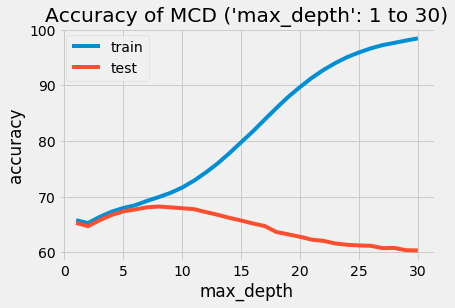

In [257]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of MCD ('max_depth': 1 to 30)")

Text(0.5, 1.0, "Accuracy of MCD ('min_samples_leaf': 1 to 50)")

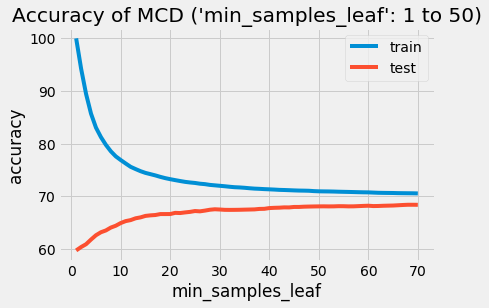

In [258]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of MCD ('min_samples_leaf': 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 8. For 'min_samples_leaf', as the value increases, the accuracy converges to around 69.2.**

In [259]:
# Decision tree using the best values of parameter
dt_best = tree.DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 20)
dt_best.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [260]:
# Predict on the train dataset and get accuracy
predictions = dt_best.predict(X_train)
errors_train = abs(predictions - y_train)
mape_train = np.mean(100*(errors_train/y_train))
mcd_accuracy_train = 100 - mape_train

# Predict on the test dataset and get accuracy
predictions = dt_best.predict(X_test)
errors_test = abs(predictions - y_test)
mape_test = np.mean(100*(errors_test/y_test))
mcd_accuracy_test = 100 - mape_test

print("[MCD] Accuracy for Train: ", round(np.mean(mcd_accuracy_train),2), "%.")
print("[MCD] Accuracy for Test: ", round(np.mean(mcd_accuracy_test),2), "%.")

[MCD] Accuracy for Train:  69.62 %.
[MCD] Accuracy for Test:  68.35 %.


In [261]:
# Plot Decision Tree to 3 level ('max_depth = 3')
dt_small = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 20)
dt_small.fit(X_train, y_train)
export_graphviz(dt_small, out_file = 'mcd_small_tree.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('mcd_small_tree.dot')
graph_best.write_png('mcd_small_tree.png')

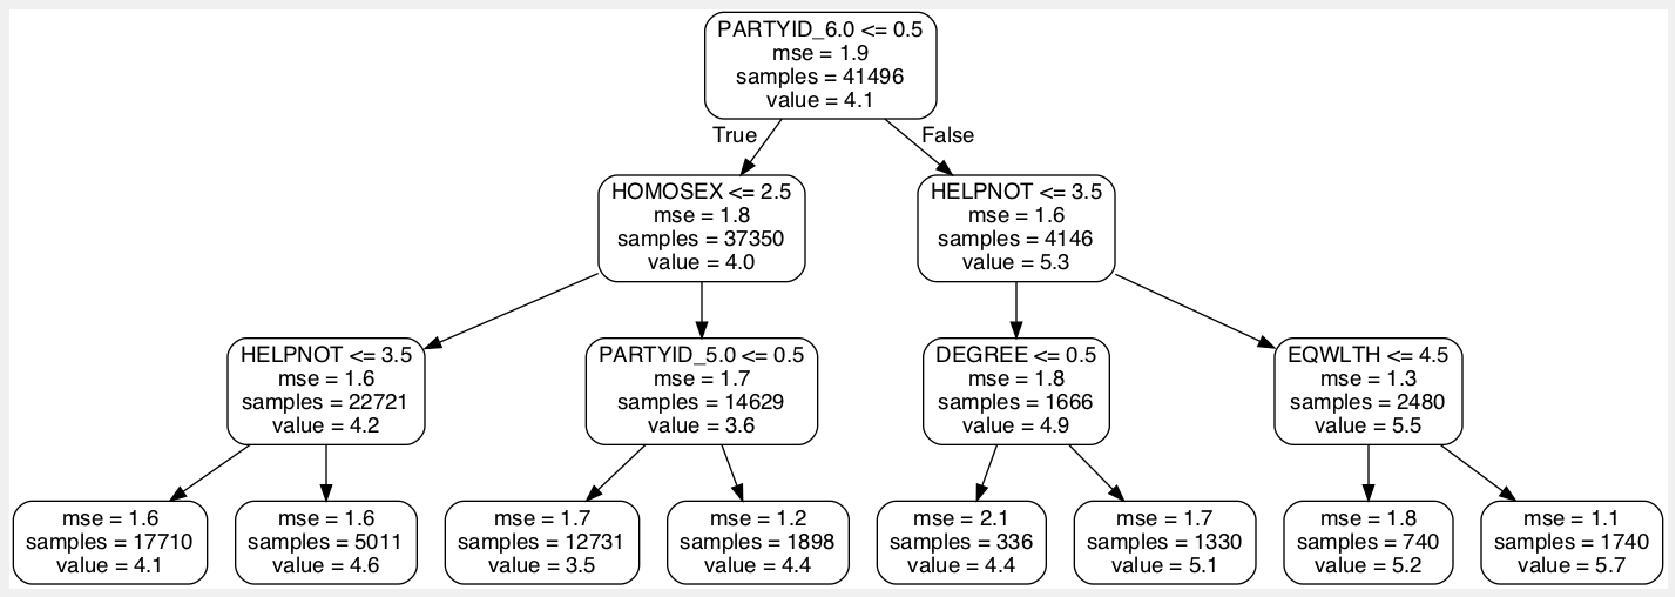

In [262]:
plot_decisiontree('mcd_small_tree.png')

In [263]:
# Get numerical feature importances
importances = list(dt_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.3
Variable: HOMOSEX              Importance: 0.18
Variable: HELPNOT              Importance: 0.09
Variable: PARTYID_5.0          Importance: 0.09
Variable: PARTYID_4.0          Importance: 0.07
Variable: EDUC                 Importance: 0.05
Variable: PREMARSX             Importance: 0.03
Variable: EQWLTH               Importance: 0.03
Variable: CAPPUN_2.0           Importance: 0.02
Variable: PARTYID_3.0          Importance: 0.02
Variable: RELITEN              Importance: 0.01
Variable: HELPSICK             Importance: 0.01
Variable: ATTEND               Importance: 0.01
Variable: RINCOME              Importance: 0.01
Variable: DEGREE               Importance: 0.01
Variable: PAEDUC               Importance: 0.01
Variable: AGE                  Importance: 0.01
Variable: RACE_2               Importance: 0.01
Variable: PRESTG10             Importance: 0.0
Variable: PAPRES10             Importance: 0.0
Variable: FAIR                 Importance: 

### *MCR (Multivariate Feature Imputation - Continuous output - Random Forest)*

In [264]:
# The number of features is 111, and we set up n_estimators 10 (around the square root of 111)
# Random Forest with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    rf = RandomForestRegressor(max_depth = vec_max_depth[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_accuracy[i] = 100-mape_train
    predictions = rf.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_accuracy[i] = 100-mape_test
print(vec_train_accuracy)
print(vec_test_accuracy)

[65.76305091 65.21641696 66.48060486 67.4293409  68.29443225 68.8069136
 69.47730788 70.14409674 70.87070923 71.73638921 72.704346   73.79434072
 75.00717965 76.27355159 77.6144606  78.92602713 80.18309032 81.37179949
 82.39860812 83.34722614 84.14628232 84.79293258 85.32729425 85.8521124
 86.2222302  86.55631149 86.82695844 87.03361371 87.15398227 87.29590705]
[65.28034039 64.68003088 65.89969085 66.81064322 67.66996565 68.05118669
 68.42736555 68.69443545 68.86625124 68.93731558 68.93864915 68.94215204
 68.879539   68.84122209 68.64570399 68.54439893 68.58110432 68.46026772
 68.49407523 68.40685174 68.30505191 68.19138032 68.12587205 68.16788412
 68.09541393 68.02244187 68.05785071 67.98248241 67.90970938 67.96831495]


In [265]:
# Random Forest with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 50
vec_min_samples_leaf = np.arange(1,51)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    rf = RandomForestRegressor(min_samples_leaf = vec_min_samples_leaf[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    errors_train = abs(predictions - y_train)
    mape_train = np.mean(100*(errors_train/y_train))
    vec_train_min_sample_accuracy[i] = 100-mape_train
    predictions = rf.predict(X_test)
    errors_test = abs(predictions - y_test)
    mape_test = np.mean(100*(errors_test/y_test))
    vec_test_min_sample_accuracy[i] = 100-mape_test
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[87.57868228 85.70187544 83.72286118 81.95244555 80.44090621 79.21731362
 78.21550685 77.46964951 76.76612858 76.18192737 75.68388601 75.23581298
 74.880721   74.59114139 74.29960805 74.04600126 73.81657763 73.61710334
 73.41284688 73.22913393 73.07245772 72.93939329 72.8028169  72.67495983
 72.5666184  72.45173959 72.35758018 72.26891798 72.1819425  72.09517179
 72.02080792 71.9572911  71.88978508 71.81932812 71.75906447 71.70404601
 71.64839345 71.59354837 71.54055527 71.48164358 71.43758464 71.3979917
 71.34970754 71.31753672 71.28311544 71.23643043 71.1730802  71.146151
 71.11419844 71.07486972]
[67.92805847 68.08644323 68.35442541 68.40386985 68.52757667 68.68537069
 68.70509684 68.75081217 68.87814834 68.90774686 68.88539224 68.90242369
 68.92716489 68.95885611 68.94762947 69.00834961 69.02579039 69.04032653
 69.05118576 69.06363742 69.03100886 69.03161357 69.04281096 69.01696875
 69.00209132 69.01753061 68.99782604 69.01027627 69.01636401 69.00852976
 69.01658261 69.00618127 68.

Text(0.5, 1.0, "Accuracy of MCR ('max_depth' varies 1 to 30)")

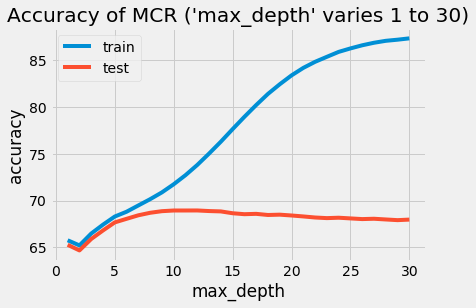

In [266]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of MCR ('max_depth' varies 1 to 30)")

Text(0.5, 1.0, "Accuracy of MCR ('min_samples_leaf' varies 1 to 50)")

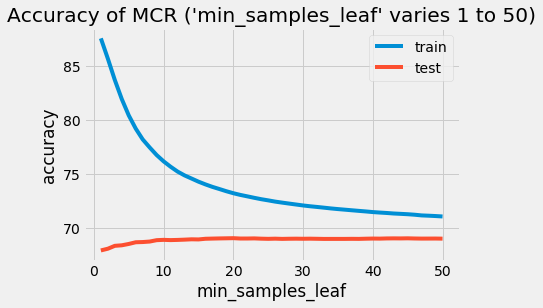

In [267]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of MCR ('min_samples_leaf' varies 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 12. For 'min_samples_leaf', as the value increases, the accuracy converges to around 69.9.**

In [268]:
# Random Forest using the best values of parameter
rf_best = RandomForestRegressor(max_depth = 12, min_samples_leaf = 20, n_estimators = 10, random_state = 123)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [269]:
# Predict on the train dataset and get accuracy
predictions = rf_best.predict(X_train)
errors_train = abs(predictions - y_train)
mape_train = np.mean(100*(errors_train/y_train))
mcr_accuracy_train = 100 - mape_train

# Predict on the test dataset and get accuracy
predictions = rf_best.predict(X_test)
errors_test = abs(predictions - y_test)
mape_test = np.mean(100*(errors_test/y_test))
mcr_accuracy_test = 100 - mape_test

print("[MCR] Accuracy for Train: ", round(np.mean(mcr_accuracy_train),2), "%.")
print("[MCR] Accuracy for Test: ", round(np.mean(mcr_accuracy_test),2), "%.")

[MCR] Accuracy for Train:  71.78 %.
[MCR] Accuracy for Test:  69.18 %.


In [270]:
# Plot One of the Random Forest Trees to 3 level ('max_depth = 3')
rf_small = RandomForestRegressor(max_depth = 3, min_samples_leaf = 20, n_estimators = 10, random_state = 123)
rf_small.fit(X_train, y_train)
tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'mcr_small.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('mcr_small.dot')
graph_best.write_png('mcr_small.png')

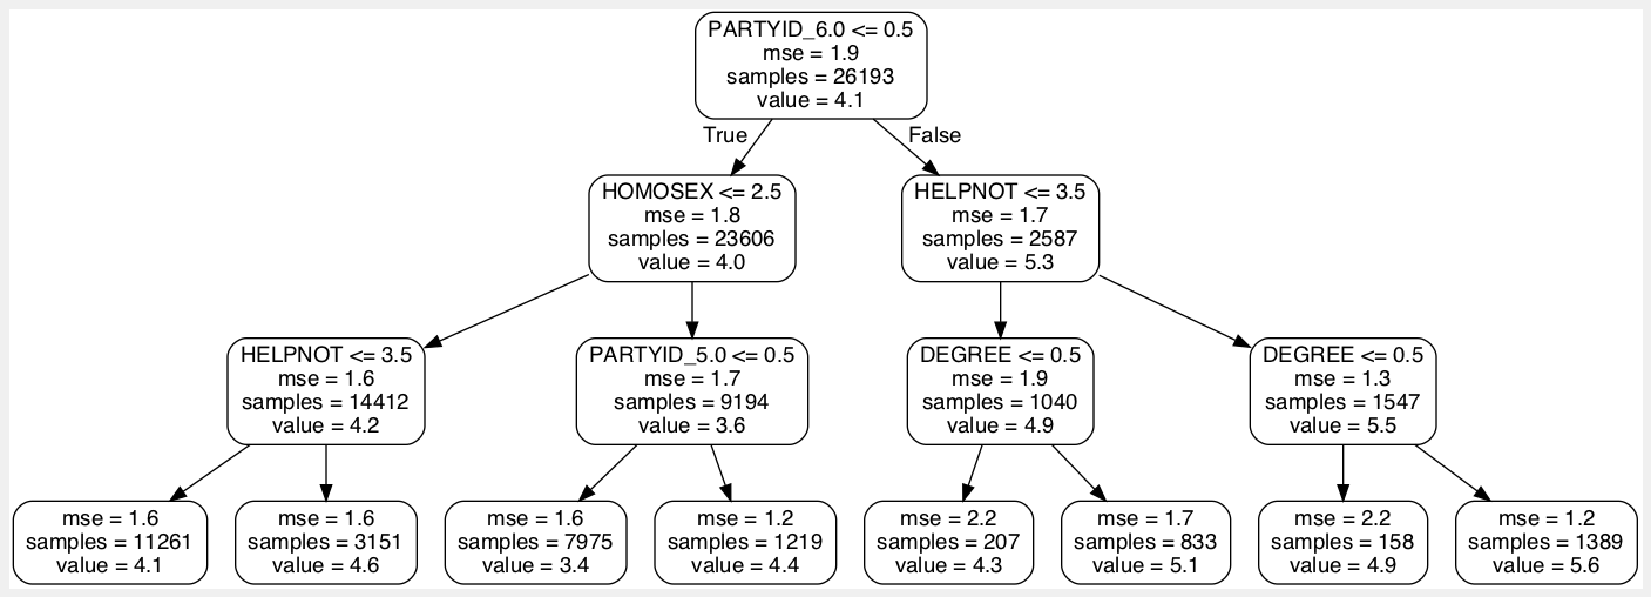

In [271]:
plot_decisiontree('mcr_small.png')

In [272]:
# Get numerical feature importances
importances = list(rf_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PARTYID_6.0          Importance: 0.22
Variable: HOMOSEX              Importance: 0.14
Variable: HELPNOT              Importance: 0.06
Variable: PARTYID_5.0          Importance: 0.06
Variable: PARTYID_4.0          Importance: 0.05
Variable: EDUC                 Importance: 0.04
Variable: EQWLTH               Importance: 0.03
Variable: AGE                  Importance: 0.03
Variable: CAPPUN_2.0           Importance: 0.03
Variable: HELPSICK             Importance: 0.02
Variable: PREMARSX             Importance: 0.02
Variable: ATTEND               Importance: 0.02
Variable: PRESTG10             Importance: 0.01
Variable: PAPRES10             Importance: 0.01
Variable: RELITEN              Importance: 0.01
Variable: HELPPOOR             Importance: 0.01
Variable: HELPBLK              Importance: 0.01
Variable: NEWS                 Importance: 0.01
Variable: FUND                 Importance: 0.01
Variable: TVHOURS              Importance: 0.01
Variable: HRS1                 Importanc

### *MBD (Multivariate Feature Imputation - Binary output - Decision Tree)*

In [307]:
# Reload our basic dataset
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16], axis=1)

In [308]:
# Drop NaN from "POLVIEWS" (dependent variable)
df.dropna(subset=['POLVIEWS'], inplace = True)
df.reset_index(inplace = True)

In [309]:
# Remove Moderate view (POLVIEWS = 4)
df = df[df.POLVIEWS != 4]
# Change extremely liberal(=1), liberal(=2), and slighly liberal(=3) to 0
df['POLVIEWS'] = df['POLVIEWS'].replace([1,2,3], 0)
# Change extremely conservative(=7), conservative(=6), and slighly conservative(=5) to 1
df['POLVIEWS'] = df['POLVIEWS'].replace([5,6,7], 1)

In [310]:
# Check 'POLVIEWS'
df['POLVIEWS'].unique()

array([1., 0.])

In [311]:
# Get the label value we want to predict, separate it from the feature dataframe
labels = np.array(df['POLVIEWS'])
df = df.drop('POLVIEWS', axis=1)
feature_list = list(df.columns)

In [312]:
# One-hot encoding for transforming categorical variables.
cat_var = ['REGION', 'POSTLIFE', 'TRUST', 'RICHWORK', 'RACLIVE', 'FINALTER', 'ABANY', 'XMOVIE',
           'FEAR', 'OWNGUN', 'HUNT','SEX', 'RACE', 'BORN', 'CAPPUN', 'GUNLAW', 'GRASS', 
           'WRKSTAT', 'MARITAL','SPREL', 'RELIG', 
           'PARTYID']
df_dum = pd.get_dummies(df, columns = cat_var, drop_first = True)

In [313]:
# Impute missing value using multiple imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [314]:
# Impute with max_iter = 10
imp = IterativeImputer(max_iter = 10, random_state = 3)
imp.fit(df_dum)
feature = np.round(imp.transform(df_dum))

In [315]:
# Transform feature array to data frame
imp_df = pd.DataFrame(feature, columns = df_dum.columns)
imp_df = imp_df.drop('index', axis = 1)

In [316]:
imp_df.head()

,PRESTG10,PAPRES10,RELITEN,FAIR,JOBFIND,SATJOB,SATFIN,LIFE,HAPPY,HAPMAR,...,RELIG_11.0,RELIG_12.0,RELIG_13.0,PARTYID_1.0,PARTYID_2.0,PARTYID_3.0,PARTYID_4.0,PARTYID_5.0,PARTYID_6.0,PARTYID_7.0
0,66.0,49.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.0,46.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36.0,34.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,37.0,46.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45.0,38.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [318]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(imp_df, labels, test_size = 0.25, random_state = 3)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (25468, 111)
Training Labels Shape: (25468,)
Testing Features Shape: (8490, 111)
Testing Labels Shape: (8490,)


In [319]:
# Decision tree with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    dt = tree.DecisionTreeRegressor(max_depth = vec_max_depth[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    vec_train_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = dt.predict(X_test)
    vec_test_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_accuracy)
print(vec_test_accuracy)

[0.65069892 0.68132559 0.69938747 0.70798649 0.72027643 0.72714779
 0.73825978 0.74740851 0.76146537 0.77940946 0.80190828 0.82240459
 0.84835872 0.8695618  0.89272813 0.91094707 0.92822365 0.94279095
 0.95429559 0.96532904 0.97290718 0.98040678 0.98594314 0.98943773
 0.99171509 0.99359981 0.99493482 0.99626983 0.99725145 0.99807602]
[0.65418139 0.67750294 0.69034158 0.70647821 0.71707892 0.72650177
 0.7213192  0.7204947  0.71590106 0.71213192 0.70282686 0.69363958
 0.69010601 0.68551237 0.67491166 0.67491166 0.67797409 0.67043581
 0.6656066  0.66607774 0.66819788 0.66030624 0.66242638 0.65418139
 0.65641932 0.65853946 0.65795053 0.65712603 0.65889282 0.65382803]


In [321]:
# Decision tree with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 70
vec_min_samples_leaf = np.arange(1,71)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    dt = tree.DecisionTreeRegressor(min_samples_leaf = vec_min_samples_leaf[i])
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_train)
    vec_train_min_sample_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = dt.predict(X_test)
    vec_test_min_sample_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[1.         0.95983195 0.93725459 0.91051516 0.8934349  0.87615832
 0.86288676 0.85259934 0.84415737 0.83544055 0.82986493 0.82338621
 0.81808544 0.81396262 0.81074289 0.80764096 0.80520653 0.80206534
 0.79970944 0.79645045 0.79397676 0.79158159 0.78902937 0.78643788
 0.78474949 0.78404272 0.78251139 0.78196168 0.78046961 0.7784671
 0.77634679 0.77579708 0.77528663 0.77399089 0.77348045 0.77257735
 0.77163499 0.77128161 0.77092822 0.77026072 0.76912204 0.76755144
 0.76625569 0.76550966 0.76448877 0.76397833 0.76335009 0.76205434
 0.76162243 0.76197581 0.7614261  0.7607586  0.76052301 0.76028742
 0.75993403 0.75895241 0.75836344 0.75785299 0.75757814 0.75655725
 0.75659651 0.75643945 0.75592901 0.75502591 0.75514371 0.75427988
 0.75408356 0.75321973 0.75310193 0.75286634]
[0.65959953 0.65371025 0.66584217 0.66513545 0.67514723 0.67738516
 0.67820966 0.6795053  0.68303887 0.68633687 0.68669022 0.68939929
 0.68621908 0.68657244 0.69234393 0.69387515 0.69658422 0.69764429
 0.70129564 0.699

Text(0.5, 1.0, "Accuracy of MBD ('max_depth': 1 to 30)")

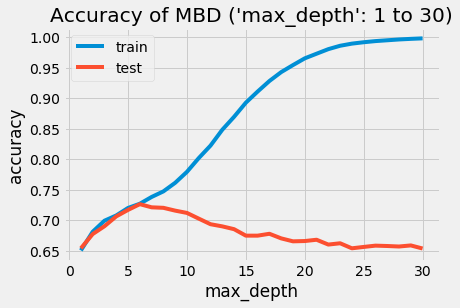

In [322]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of MBD ('max_depth': 1 to 30)")

Text(0.5, 1.0, "Accuracy of MBD ('min_samples_leaf': 1 to 50)")

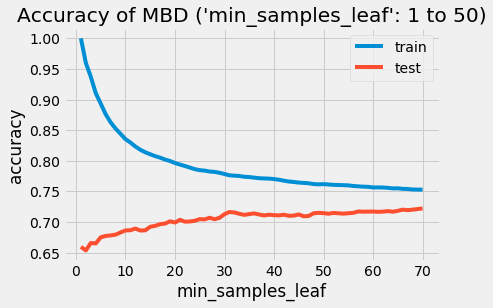

In [323]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of MBD ('min_samples_leaf': 1 to 50)")

**$\rightarrow$ The best parameters of 'max_depth' and 'min_samples_leaf' are 6 and 32, respectively.**

In [324]:
# Decision tree using the best values of parameter
dt_best = tree.DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 32)
dt_best.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=32, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [325]:
# Predict on the train dataset and get accuracy
predictions = dt_best.predict(X_train)
mbd_accuracy_train = ((predictions.round()==y_train).sum()/len(y_train))*100
# Predict on the test dataset and get accuracy
predictions = dt_best.predict(X_test)
mbd_accuracy_test = ((predictions.round()==y_test).sum()/len(y_test))*100

print("[MBD] Accuracy for Train: ", round(np.mean(mbd_accuracy_train),2), "%.")
print("[MBD] Accuracy for Test: ", round(np.mean(mbd_accuracy_test),2), "%.")

[MBD] Accuracy for Train:  72.62 %.
[MBD] Accuracy for Test:  72.76 %.


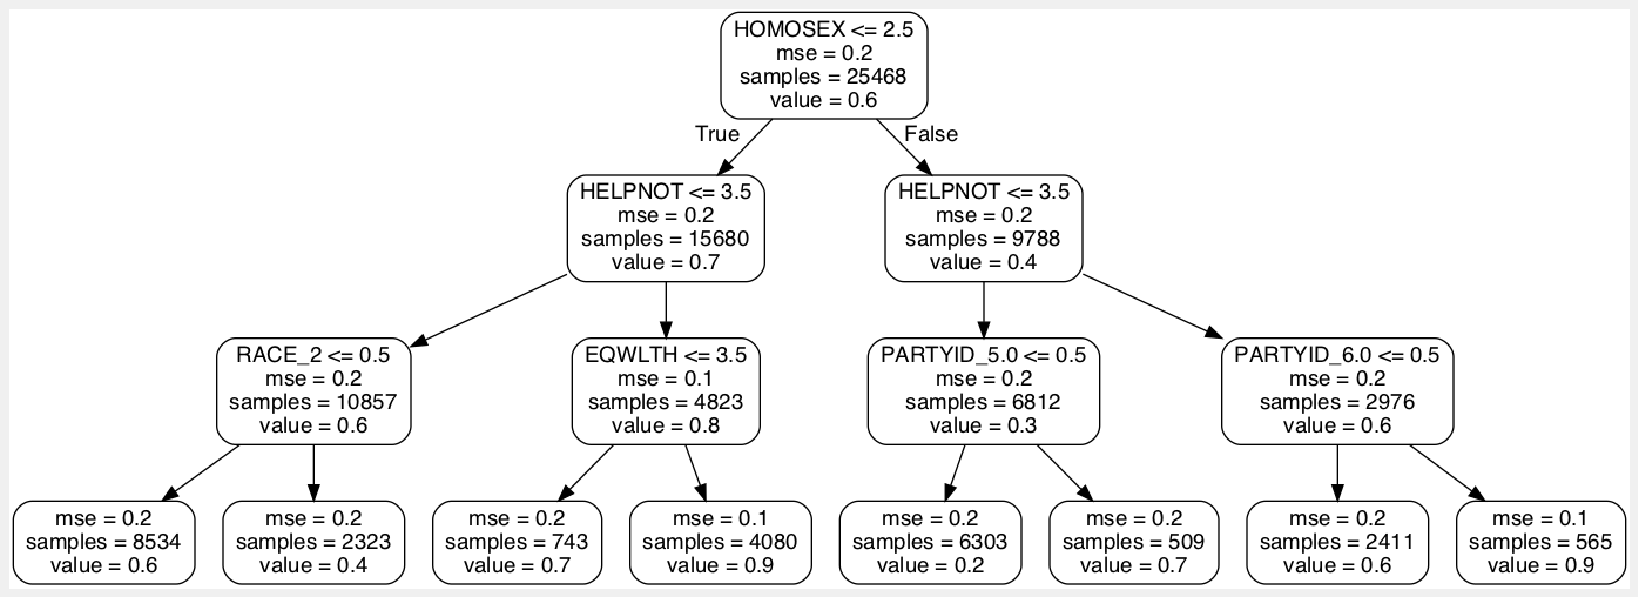

In [290]:
# Plot Decision Tree to 3 level ('max_depth = 3')
dt_small = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 32)
dt_small.fit(X_train, y_train)
export_graphviz(dt_small, out_file = 'mbd_small_tree.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('mbd_small_tree.dot')
graph_best.write_png('mbd_small_tree.png')

plot_decisiontree('mbd_small_tree.png')

In [291]:
# Get numerical feature importances
importances = list(dt_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: HOMOSEX              Importance: 0.29
Variable: HELPNOT              Importance: 0.28
Variable: PARTYID_5.0          Importance: 0.11
Variable: PARTYID_6.0          Importance: 0.1
Variable: PARTYID_4.0          Importance: 0.06
Variable: RACE_2               Importance: 0.04
Variable: EDUC                 Importance: 0.03
Variable: PREMARSX             Importance: 0.02
Variable: HELPSICK             Importance: 0.01
Variable: EQWLTH               Importance: 0.01
Variable: ATTEND               Importance: 0.01
Variable: INCOME               Importance: 0.01
Variable: CAPPUN_2.0           Importance: 0.01
Variable: PRESTG10             Importance: 0.0
Variable: PAPRES10             Importance: 0.0
Variable: RELITEN              Importance: 0.0
Variable: FAIR                 Importance: 0.0
Variable: JOBFIND              Importance: 0.0
Variable: SATJOB               Importance: 0.0
Variable: SATFIN               Importance: 0.0
Variable: LIFE                 Importance: 0.0
V

### *MBR (Multivariate Feature Imputation - Binary output - Random Forest)*

In [326]:
# The number of features is 111, and we set up n_estimators 10 (around the square root of 111)
# Random Forest with various values of 'max_depth' and each accuracy
# Set 'max_depth' 1 to 30
vec_max_depth = np.arange(1,31)
vec_train_accuracy = np.zeros(len(vec_max_depth))
vec_test_accuracy = np.zeros(len(vec_max_depth))

for i in range(len(vec_max_depth)):
    rf = RandomForestRegressor(max_depth = vec_max_depth[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    vec_train_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = rf.predict(X_test)
    vec_test_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_accuracy)
print(vec_test_accuracy)

[0.65069892 0.68132559 0.70621957 0.71018533 0.7293859  0.73955552
 0.74976441 0.7631145  0.78616303 0.81054657 0.83999529 0.86830532
 0.89378828 0.91907492 0.93760798 0.95162557 0.96360138 0.9708654
 0.97695147 0.98076017 0.9830768  0.98527564 0.98578608 0.98668918
 0.98696403 0.98719962 0.98731742 0.98668918 0.9868855  0.98653212]
[0.65418139 0.67750294 0.70129564 0.70400471 0.72367491 0.7335689
 0.73297998 0.73309776 0.73733804 0.73616019 0.73015312 0.72591284
 0.72320377 0.72402827 0.72155477 0.72120141 0.71625442 0.71248528
 0.70800942 0.70883392 0.70954064 0.70706714 0.71048292 0.71319199
 0.71083628 0.71130742 0.70965842 0.71224971 0.71001178 0.70789164]


In [327]:
# Random Forest with various values of 'min_samples_leaf' and each accuracy
# Set 'min_samples_leaf' 1 to 50
vec_min_samples_leaf = np.arange(1,51)
vec_train_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))
vec_test_min_sample_accuracy = np.zeros(len(vec_min_samples_leaf))

for i in range(len(vec_min_samples_leaf)):
    rf = RandomForestRegressor(min_samples_leaf = vec_min_samples_leaf[i], n_estimators = 10, random_state = 123)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_train)
    vec_train_min_sample_accuracy[i] = (predictions.round()==y_train).sum()/len(y_train)
    predictions = rf.predict(X_test)
    vec_test_min_sample_accuracy[i] = (predictions.round()==y_test).sum()/len(y_test)
print(vec_train_min_sample_accuracy)
print(vec_test_min_sample_accuracy)

[0.98637506 0.97384954 0.95625883 0.9378043  0.92382598 0.90780587
 0.89610492 0.88302968 0.87207476 0.86492854 0.85676143 0.84934035
 0.84184074 0.83846395 0.83139626 0.82770536 0.82354327 0.82173708
 0.81557248 0.81247055 0.809722   0.80646301 0.80430344 0.8014371
 0.7976284  0.79629339 0.7943694  0.79338778 0.78997173 0.78792995
 0.78718392 0.78726245 0.78447463 0.78380713 0.78196168 0.78129417
 0.77956651 0.77921313 0.77791739 0.77701429 0.77595414 0.77481545
 0.77242029 0.77277368 0.77297    0.77242029 0.77190985 0.77045704
 0.76959322 0.76939689]
[0.70871614 0.70906949 0.72638398 0.72414605 0.72320377 0.72720848
 0.72520612 0.72826855 0.73297998 0.73227326 0.73321555 0.73168433
 0.73180212 0.73545347 0.73097762 0.73133098 0.73545347 0.73404005
 0.73486455 0.73533569 0.73510012 0.73545347 0.73710247 0.73427562
 0.73757362 0.73568905 0.73722026 0.73568905 0.7368669  0.73674912
 0.73816254 0.73545347 0.7352179  0.73663133 0.73651355 0.73863369
 0.7385159  0.73828033 0.73839812 0.738

Text(0.5, 1.0, "Accuracy of MBR ('max_depth' varies 1 to 30)")

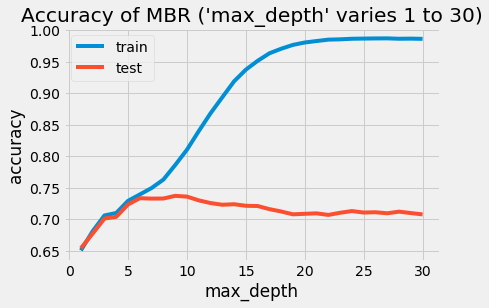

In [331]:
# Plot accuracy (max_depth varies)
plt.plot(vec_max_depth, vec_train_accuracy, label = 'train')
plt.plot(vec_max_depth, vec_test_accuracy, label = 'test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy of MBR ('max_depth' varies 1 to 30)")

Text(0.5, 1.0, "Accuracy of MBR ('min_samples_leaf' varies 1 to 50)")

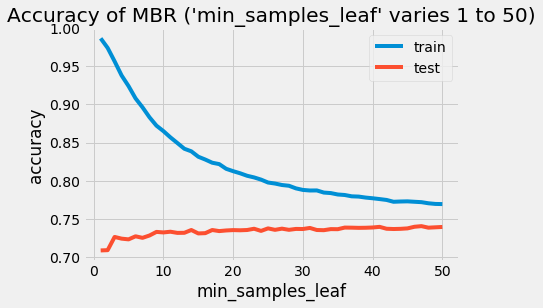

In [332]:
# Plot accuracy (min_samples_leaf varies)
plt.plot(vec_min_samples_leaf, vec_train_min_sample_accuracy, label = 'train')
plt.plot(vec_min_samples_leaf, vec_test_min_sample_accuracy, label = 'test')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy of MBR ('min_samples_leaf' varies 1 to 50)")

**$\rightarrow$ The best parameter of 'max_depth' is 9. For 'min_samples_leaf', as the value increases, the accuracy converges to around 74.0.**

In [333]:
# Random Forest using the best values of parameter
rf_best = RandomForestRegressor(max_depth = 14, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=25,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [334]:
# Predict on the train dataset and get accuracy
predictions = rf_best.predict(X_train)
mbr_accuracy_train = ((predictions.round()==y_train).sum()/len(y_train))*100
# Predict on the test dataset and get accuracy
predictions = rf_best.predict(X_test)
mbr_accuracy_test = ((predictions.round()==y_test).sum()/len(y_test))*100

print("[MBR] Accuracy for Train: ", round(np.mean(mbr_accuracy_train),2), "%.")
print("[MBR] Accuracy for Test: ", round(np.mean(mbr_accuracy_test),2), "%.")


[MBR] Accuracy for Train:  79.29 %.
[MBR] Accuracy for Test:  73.78 %.


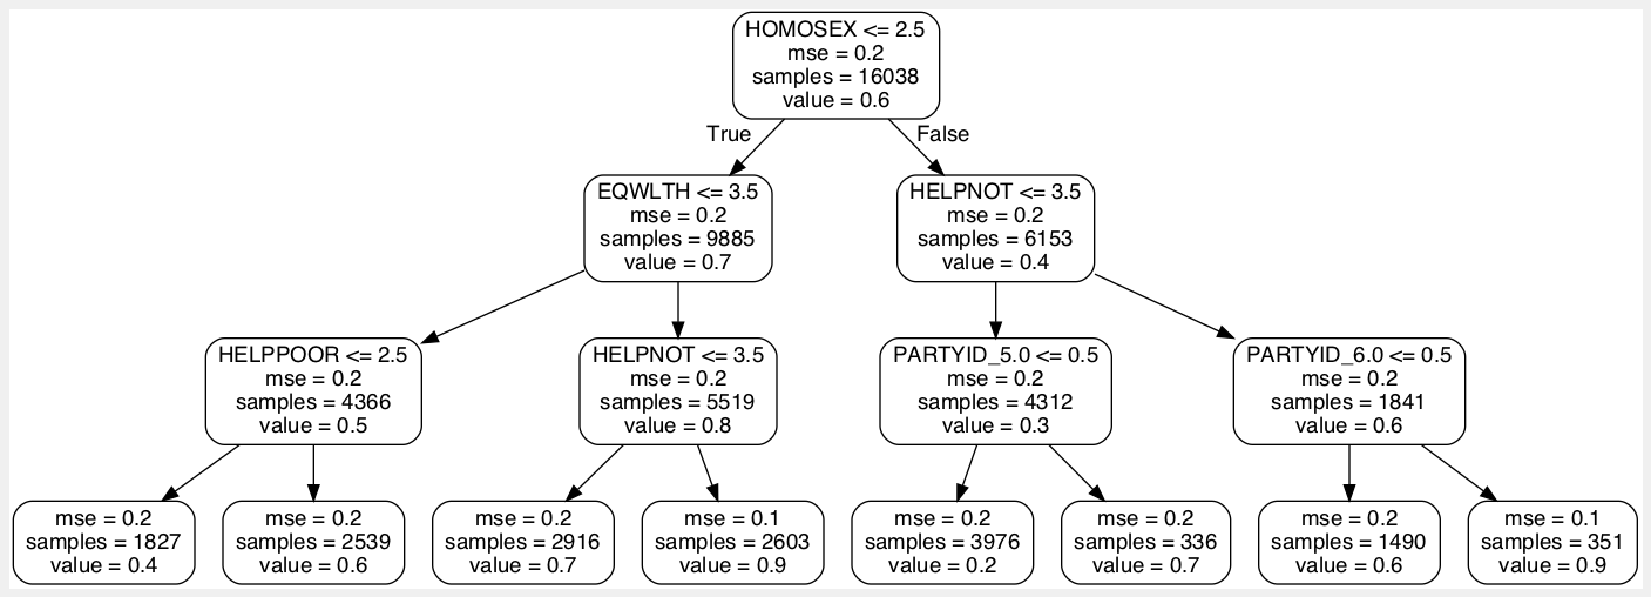

In [298]:
# Plot One of the Random Forest Trees to 3 level ('max_depth = 3')
rf_small = RandomForestRegressor(max_depth = 3, min_samples_leaf = 25, n_estimators = 10, random_state = 123)
rf_small.fit(X_train, y_train)
tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'mbr_small.dot', feature_names = imp_df.columns, rounded = True, precision = 1)
(graph_best, ) = pydot.graph_from_dot_file('mbr_small.dot')
graph_best.write_png('mbr_small.png')

plot_decisiontree('mbr_small.png')

In [299]:
# Get numerical feature importances
importances = list(rf_best.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_df.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: HOMOSEX              Importance: 0.18
Variable: HELPNOT              Importance: 0.15
Variable: PARTYID_5.0          Importance: 0.07
Variable: PARTYID_6.0          Importance: 0.07
Variable: EQWLTH               Importance: 0.05
Variable: PARTYID_4.0          Importance: 0.05
Variable: EDUC                 Importance: 0.04
Variable: PREMARSX             Importance: 0.03
Variable: AGE                  Importance: 0.03
Variable: PRESTG10             Importance: 0.02
Variable: HELPBLK              Importance: 0.02
Variable: ATTEND               Importance: 0.02
Variable: RACE_2               Importance: 0.02
Variable: PAPRES10             Importance: 0.01
Variable: HELPPOOR             Importance: 0.01
Variable: HELPSICK             Importance: 0.01
Variable: NEWS                 Importance: 0.01
Variable: FUND                 Importance: 0.01
Variable: TVHOURS              Importance: 0.01
Variable: HRS1                 Importance: 0.01
Variable: CHILDS               Importanc

## 4. Results

### 4.1. Importance of Key Features

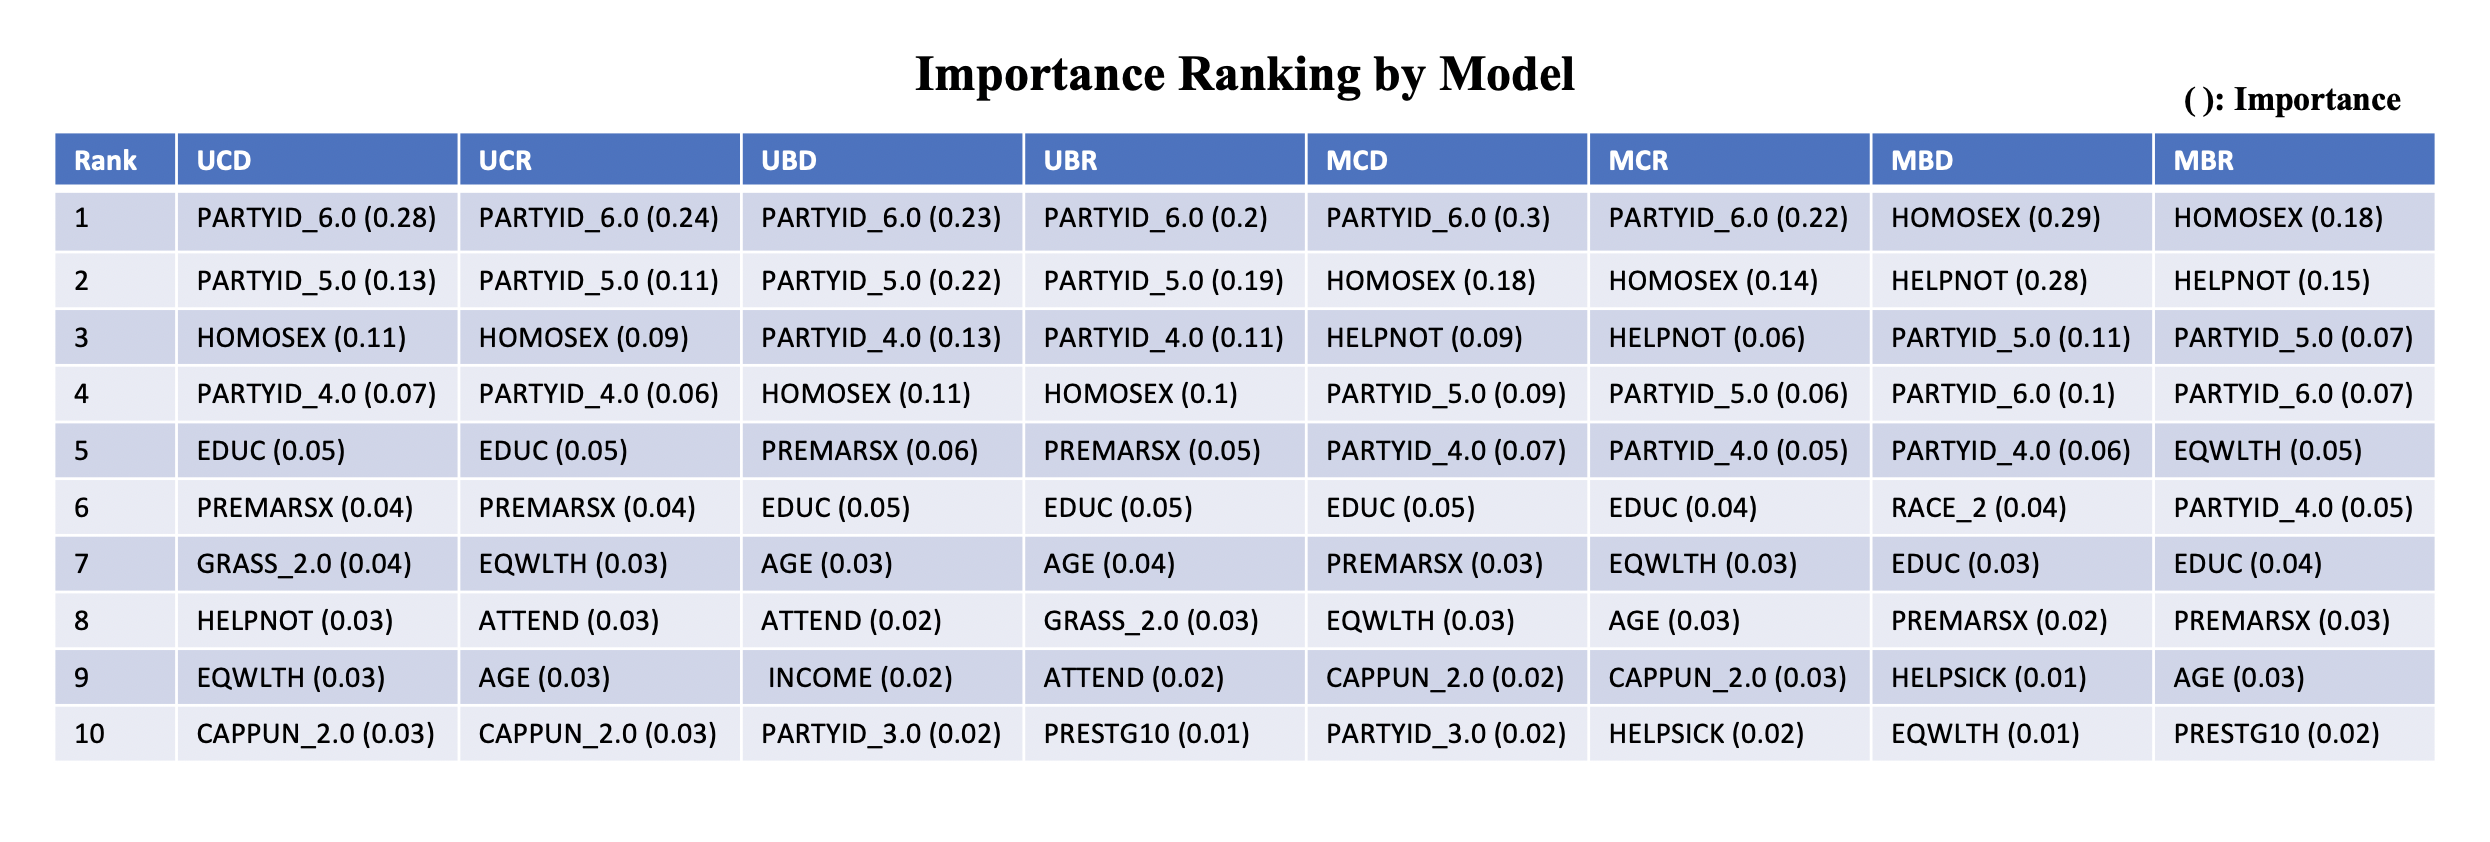

In [300]:
Image.open('importance_table.png')

As seen in the table of importance ranking above, ```PARTYID_6.0``` which indicates "strong republican" was chosen as the root node in 6 models out of 8. In other two models, MBD and MBR, ```HOMOSEX```, which is how much a respondent support the same sex relations, was the root node. The top 10 rankers are very similar in all models, and it means the results are robust to a large extent. Thus, the key features related to one's political orientation are one's political party affiliation (```PARTYID```), education level (```EDUC```), age (```AGE```), participation in religious services (```ATTEND```), legalization of marijuana (```GRASS```), government's role (```HELPNOT```), income difference (```EQWLTH```), sex before marriage (```PREMARSX```), occupational prestige score (```PRESTG10```), etc.
More specifically, according to the result of the MBR model (please refer to the MBR tree right above), an individual who think that the same sex is always wrong (```HOMOSEX```$=1$) goes to left side from the root node. Then asked that government should reduce income differences, and she thinks no government action needed (```EQWITH```$=7$), so now goes to the right side. Lastly, she is asked if she thinks the government's role should be larger, but she doesn't agree (```HELPNOT```$=5). Then it is very likely that her political orientaion is conservative (the value of the last node is 0.9).



### 4.2. Perfomance Comparison

As expected, the accuracy on the testing set is the highest with MBR model, followed by UBR, MBD, UBD models in order. Overall, models using Random Forest perform better than models using Decision Tree, and models using binary out perform better than continuous output models. The results of accuracy of all models on both training and testing sets are as below.

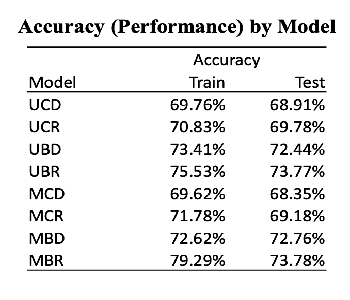

In [386]:
im2 = Image.open('performance.png')
newsize = (350, 300) 
im2.resize(newsize)

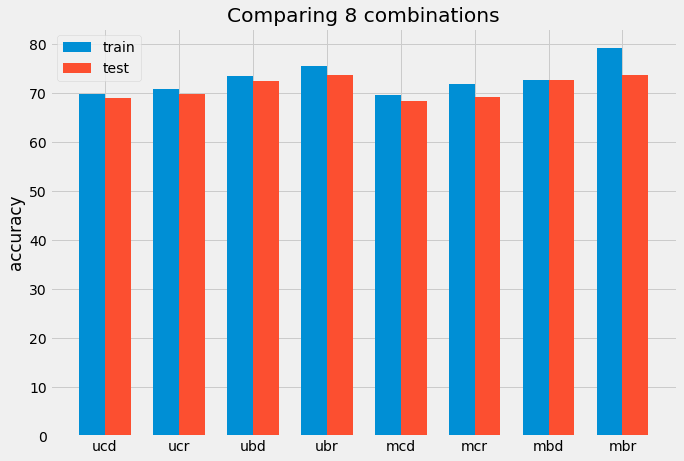

In [379]:
# Plot performance figure
plt.figure(figsize=(10,7))
N = 8
accur_train = [ucd_accuracy_train,ucr_accuracy_train,ubd_accuracy_train,ubr_accuracy_train,mcd_accuracy_train,mcr_accuracy_train,mbd_accuracy_train,mbr_accuracy_train]
accur_test = [ucd_accuracy_test,ucr_accuracy_test,ubd_accuracy_test,ubr_accuracy_test,mcd_accuracy_test,mcr_accuracy_test,mbd_accuracy_test,mbr_accuracy_test]
ind = np.arange(N)
width = 0.35
plt.bar(ind, accur_train, width, label='train')
plt.bar(ind + width, accur_test, width,
    label='test')

plt.ylabel('accuracy')
plt.title('Comparing 8 combinations')

plt.xticks(ind + width / 2, ("ucd","ucr","ubd","ubr","mcd","mcr","mbd","mbr"))
plt.legend(loc='best')


plt.show()

## 5. Conclusion

In this project, we tried to find the key features which affect the formation of individuals' political orientation using the GSS dataset. Unlike the previous literature, which mostly used traditional regression methods or applied natural language processing (NLP) to the context for detecting mere revealed orientation, our project is meaningful in that it applies nonparametric methods and tries to find more fundamental factors behind the process. Most of all, as we devised a 2 x 2 x 2 model which made 8 combinations of different methodologies and different measurements, it can be somewhat helpful to secure robustness of our project results.

As a result of this project, we found several important features which show high importance and have much information to predict one's political orientation. Individual's attitudes towards homosexual relationships, thoughts about government's intervention, legalization of marijuana, and inequality as well as some basic information such as political party affiliation, age, occupational prestige are such critical features.

## 6. Discussion

This minor contributions to the literature notwithstanding, the overall accuracy of the eight models were somehow low (ranged between 68%-74%). Although we applied 8 different models, there are still many possibilities of omitted features and measurement errors.

Handling missing values was one of the most difficult parts in this project. Notably, it was confusing in which stage , we should impute them. (i.e before or after getting dummies or separating the dataset into training and test sets.) In our project, for univariate feature imputation, we imputed missing values before transforming to dummies and splitting dataset, and for multivariate feature imputation, we did it after dummy transformation and before separating dataset. By doing so, it was unavoidable to impute missing values in the test set. Using imputed values in our test data might have brought about critical problems in our result.

## Appendix

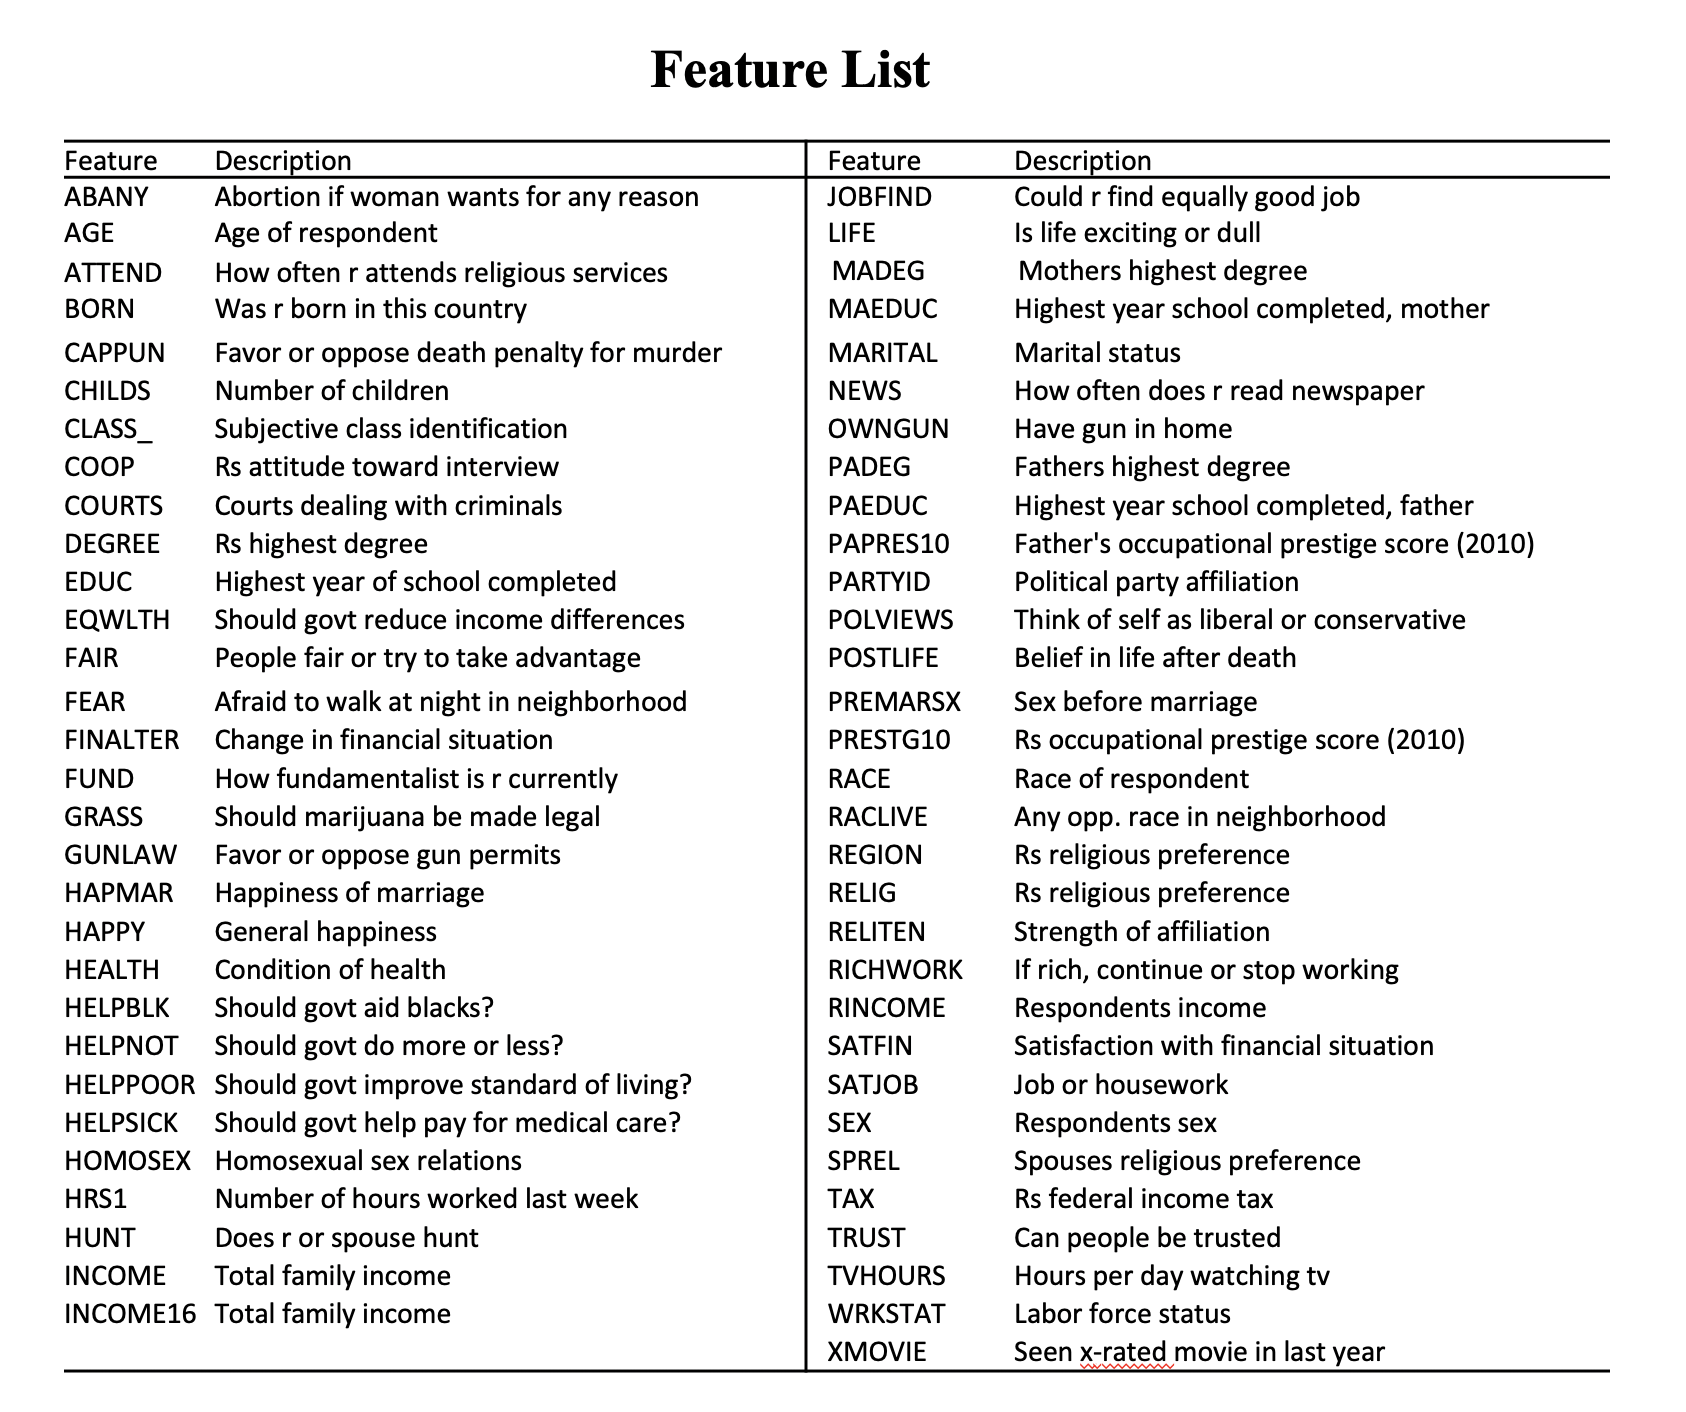

In [304]:
Image.open('feature_list.png')